NMFk example: Feature extraction
-----

An example problem demonstrating how **NMFk** can be applied to extract and clasify features and sensors observing these mixed features.

This type of analysis is related to **blind source separation**

Applying **NMFk**, we can automatically:

- identify the number of the unknown mixed signatures in dataset 
- estimate the shape of the unknown mixed signatures
- estimate how the signatures are mixed at each sensor
- clasify sensors based on how they observe (are impacted) the extracted features.

<div style="text-align: left; padding-top: 30px; padding-bottom: 30px;">
    <img src="../../logo/nmfk-logo.png" alt="NMFk" width=20% max-width=125px;/>
</div>

**NMFk** is a code within the **SmartTensors** framework.

<div style="text-align: left; padding-top: 30px; padding-bottom: 30px;">
    <img src="../../logo/SmartTensorsNewSmall.png" alt="NMFk" width=20% max-width=125px;/>
</div>

If **NMFk** is not installed, first execute in the Julia REPL: `import Pkg; Pkg.add("NMFk"); Pkg.add("Mads")`.

In [1]:
import Revise
import NMFk
import Mads
import Random

Random.seed!(2021)

MersenneTwister(2021)

Let us generate 4 random signals with legnth of 100 (this can be considered as 100 ):

In [2]:
s1 = (sin.(0.05:0.05:5) .+1) ./ 2
s2 = (sin.(0.3:0.3:30) .+ 1) ./ 2
s3 = (sin.(0.5:0.5:50) .+ 1) ./ 2
s4 = rand(100)
W = [s1 s2 s3 s4]

100×4 Matrix{Float64}:
 0.52499      0.64776     0.739713    0.405796
 0.549917     0.782321    0.920735    0.0657738
 0.574719     0.891663    0.998747    0.398162
 0.599335     0.96602     0.954649    0.163816
 0.623702     0.998747    0.799236    0.783094
 0.64776      0.986924    0.57056     0.134115
 0.671449     0.931605    0.324608    0.883121
 0.694709     0.837732    0.121599    0.386875
 0.717483     0.71369     0.0112349   0.242105
 0.739713     0.57056     0.0205379   0.131588
 0.761344     0.421127    0.14723     0.085331
 0.782321     0.27874     0.360292    0.330099
 0.802593     0.156117    0.60756     0.654601
 ⋮                                    
 0.0171135    0.999997    0.747443    0.508222
 0.0112349    0.978188    0.925452    0.199709
 0.00657807   0.913664    0.999295    0.857753
 0.0031545    0.812189    0.950894    0.130975
 0.000972781  0.682826    0.792098    0.381099
 3.83712e-5   0.537133    0.561787    0.89211
 0.000353606  0.388122    0.316347    0.18814

The singals look like this:

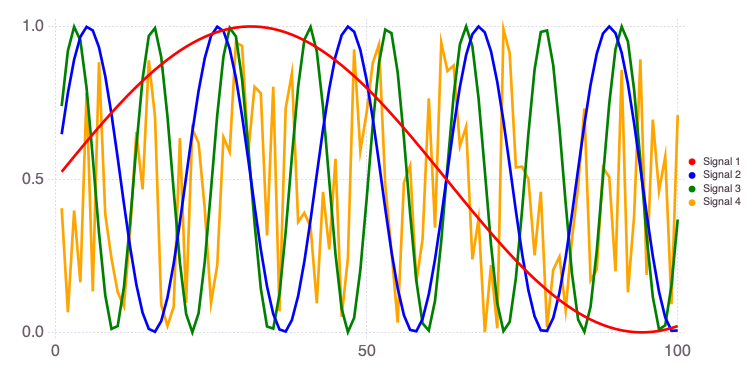

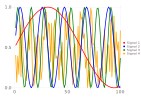

In [3]:
Mads.plotseries(W)

Now we can mix the signals in matrix `W` to produce a data matrix `X` representing data collected at 10 sensors (e.g., measurement devices or wells at different locations).

Each of the 10 sensors is observing some mixture of the 4 signals in `W`.

The way the 4 signals are mixed at the sensors is represented by the mixing matrix `H`.

Let us define the mixing matrix `H` as:

In [4]:
H = [1 5 0 0 1 1 2 1 0 2; 0 1 1 5 2 1 0 0 2 3; 3 0 0 1 0 1 0 5 4 3; 1 1 4 1 5 0 1 1 5 3]

4×10 Matrix{Int64}:
 1  5  0  0  1  1  2  1  0  2
 0  1  1  5  2  1  0  0  2  3
 3  0  0  1  0  1  0  5  4  3
 1  1  4  1  5  0  1  1  5  3

Each column of the `H` matrix defines how the 3 signals are represented in each sensors.

For example, the first sensor (column 1 above) detects only Signals 1 and 3; Signal 2 is missing because `H[2,1]` is equal to zero.

The second sensor (column 2 above) detects Signals 1, 2 and 4; Signal 3 is missing because `H[3,2]` is equal to zero.

The entries of `H` matrix also define the proportions at which the signals are mixed.

For example, the first sensor (column 1 above) detects Signal 3 times stronger than Signals 1 and 4.

The data matrix `X` is formed by multiplying `W` and `H` matrices. `X` defines the actual data observed.

In [5]:
X = W * H

100×10 Matrix{Float64}:
 3.14992   3.6785    2.27095   4.38431   …  4.62935    6.28335  6.42979
 3.3779    3.59768   1.04542   4.89812      5.21937    5.57645  6.40633
 3.96912   4.16342   2.48431   5.85523      5.96662    7.76913  8.01516
 3.6271    4.12651   1.62128   5.94856      5.53639    6.56971  7.45212
 3.8045    4.90035   4.13112   6.57607      5.40298    9.10991  8.99064
 2.49356   4.35984   1.52339   5.63929   …  3.63468    4.92666  6.37032
 2.52839   5.17197   4.46409   5.86575      3.17761    7.57725  7.7609
 1.44638   4.69815   2.38523   4.69713      1.68958    4.09623  5.42803
 0.993292  4.54321   1.68211   3.82179      1.01576    2.68284  4.33605
 0.932914  4.40071   1.09691   3.00493      0.97399    1.88121  3.64748
 1.28836   4.31318   0.762451  2.3382    …  1.58282    1.85783  3.48375
 2.1933    4.52045   1.59914   2.08409      2.91388    3.64914  4.47204
 3.27987   4.82368   2.77452   2.04275      4.49499    6.01548  5.86002
 ⋮                                       

The data matrix `X` looks like this:

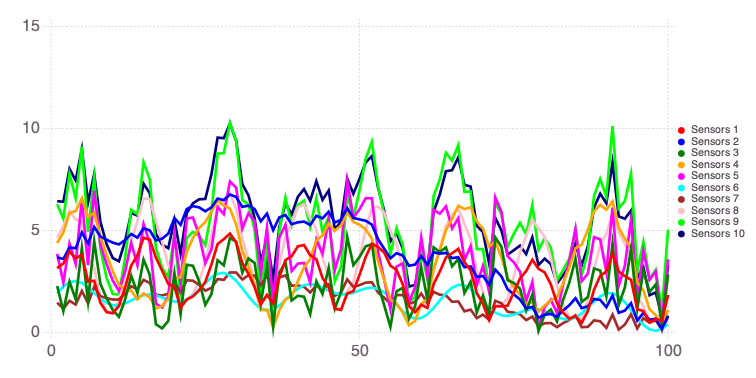

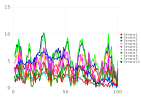

In [6]:
Mads.plotseries(X; name="Sensors")

Now, we can assume that we only know the data matrix `X` and the `W` and `H` matrices are unknown.

We can execute **NMFk** and analyze the data matrix `X`.

**NMFk** will automatically:

- identify the number of the unknown mixed signals in `X` 
- estimate the shape of the unknown mixed signals (i.e., estimate the entries of `W` matrix)
- estimate how the signals are mixed at the 5 sensors (i.e., estimate the entries of `H` matrix)

This can be done based only on the information in `X`:

In [7]:
nkrange=2:10
We, He, fitquality, robustness, aic, kopt = NMFk.execute(X, nkrange; save=false, method=:simple);


OF: min 563.4561839705091 max 571.0956047569299 mean 566.1096913459744 std 2.5162024019835187
Worst correlation by columns: 0.204840178904257
Worst correlation by rows: 0.6730840865506231
Worst covariance by columns: 0.07619556361296793
Worst covariance by rows: 0.3177632870362544
Worst norm by columns: 0.2062783776100441
Worst norm by rows: 0.5879052371885953
Signals:  2 Fit:     563.4562 Silhouette:    0.9961238 AIC:    -133.6657

OF: min 205.10453576810346 max 205.44013709359942 mean 205.2558183299092 std 0.10764194146505947
Worst correlation by columns: 0.765756624884207
Worst correlation by rows: 0.8221459244824038
Worst covariance by columns: 0.09620742799039032
Worst covariance by rows: 0.3340068356918061
Worst norm by columns: 0.20481267664903935
Worst norm by rows: 0.7412498027521249
Signals:  3 Fit:     205.1045 Silhouette:    0.9877389 AIC:    -924.2355

OF: min 0.02606110346539826 max 0.3285930894206071 mean 0.08570976712343938 std 0.09054762017310256
Worst correlation by 

┌ Info: Results
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:15
┌ Info: Optimal solution: 4 signals
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:20


**NMFk** returns the estimated optimal number of signals `kopt` which in this case, as expected, is equal to 4.

A plot of the fit and the robustness is shown below:

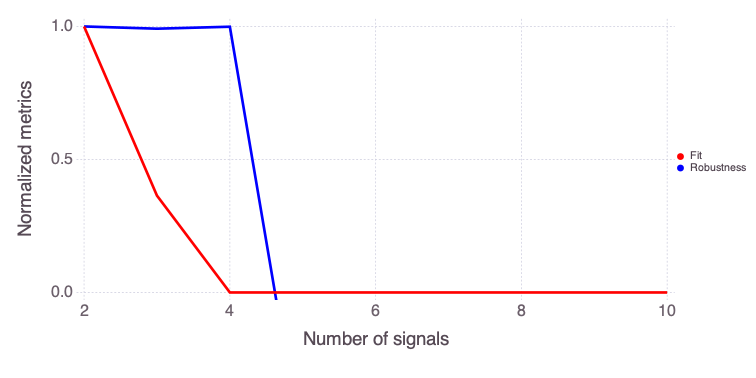

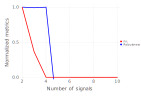

In [8]:
NMFk.plot_feature_selecton(nkrange, fitquality, robustness)

Acceptable (underfitting) solutions:

In [9]:
NMFk.getks(nkrange, robustness[nkrange])

3-element Vector{Int64}:
 2
 3
 4

**NMFk** also returns estimates of matrices `W` and `H`.

Here the estimates of matrices W and H are stored as `We` and `He` objects.

`We[kopt]` and `He[kopt]` are scaled versions of the original `W` and `H` matrices:

In [10]:
We[kopt]

100×4 Matrix{Float64}:
  6.98288       9.8499     12.8513     8.35984
  7.30996      11.8127     15.9778     0.882809
  7.62872      13.5455     17.3301     8.08025
  7.97546      14.6198     16.5393     2.98001
  8.30801      15.2631     13.8386    16.4947
  8.6807       14.9337      9.82891    2.43144
  9.00687      14.2667      5.57065   18.8057
  9.35944      12.7232      2.03126    8.06176
  9.68569      10.7992      0.115306   4.94977
  9.97687       8.59067     0.315878   2.53534
 10.2451        6.29855     2.56101    1.48994
 10.4821        4.18342     6.324      6.74894
 10.7024        2.39109    10.6801    13.7316
  ⋮                                   
  0.161788     15.3218     12.8633    10.7629
  0.000195678  14.924      15.9681     4.05281
  5.17196e-6   14.0734     17.2867    18.289
  3.18961e-15  12.3748     16.4477     2.44801
  3.61166e-11  10.4437     13.7045     7.95672
  2.1087e-7     8.34621     9.71597   19.1721
  3.1738e-8     5.93872     5.44963    3.95505
  0.

In [11]:
He[kopt]

4×10 Matrix{Float64}:
 0.0743214   0.373864    0.00599197  …  0.0734625  0.00697259  0.153705
 0.00244652  0.0645862   0.066335       0.0039405  0.135276    0.19962
 0.173145    0.00390684  0.003374       0.28775    0.233158    0.175627
 0.0457141   0.0456666   0.183246       0.0455059  0.227846    0.135591

Note that the order of columns ('signals') in `W` and `We[kopt]` are not expected to match.

Also note that the order of rows ('sensors') in `H` and `He[kopt]` are also not expected to match.

The estimated order of 'signals' will be different every time the code is executed.

Below are plots providing comparisons between the original and estimated `W` an `H` matrices.


A plot of the original signals:

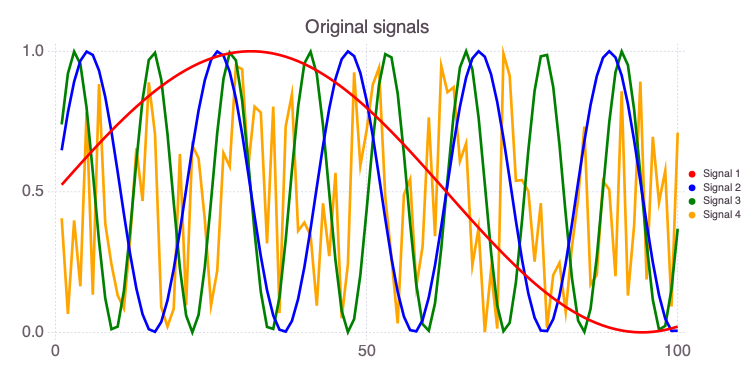

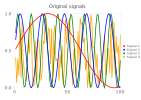

In [12]:
Mads.plotseries(W; title="Original signals")

A plot of the reconstructed signals:

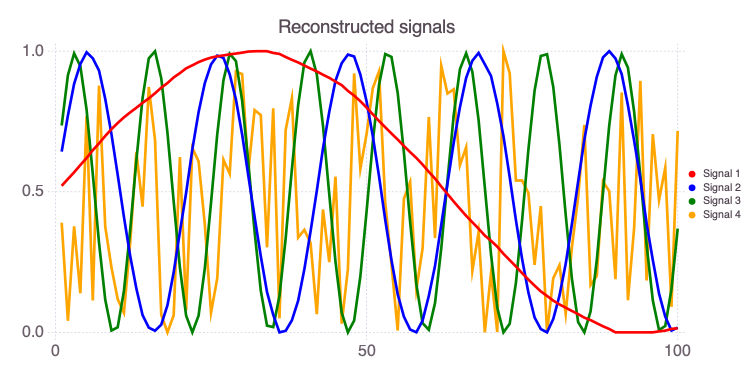

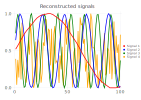

In [13]:
Mads.plotseries(We[kopt] ./ maximum(We[kopt]; dims=1); title="Reconstructed signals")

A plot of the original mixing matrix:

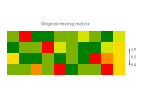

In [14]:
NMFk.plotmatrix(H ./ maximum(H; dims=2); title="Original mixing matrix")

A plot of the reconstructed mixing matrix:

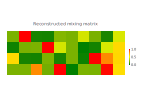

In [15]:
NMFk.plotmatrix(He[kopt] ./ maximum(He[kopt]; dims=2); title="Reconstructed mixing matrix")

Figures above demonstrate the accurate reconstruction of the original `W` and `H` matrices.

**NMFk** results can be further analyzed as demonstrated below:

Signal importance (high->low): [1, 2]


┌ Info: Number of signals: 2
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:164
┌ Info: Sensors (signals=2)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:168
┌ Warning: type Clustering.KmeansResult{Core.Array{Core.Float64,2},Core.Float64,Core.Int64} not present in workspace; reconstructing
└ @ JLD /Users/vvv/.julia/packages/JLD/JHrZe/src/jld_types.jl:697
┌ Info: Robust k-means analysis results are loaded from file ./Hmatrix-2-2_10-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:67
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: type Clustering.KmeansResult{Core.Array{Core.Float64,2},Core.Float64,Core.Int64} not present in workspace; reconstructing
└ @ JLD /Users/vvv/.julia/packages/JLD/JHrZe/src/jld_types.jl:697

2×2 Matrix{Any}:
 "s2"  0.816528
 "s7"  0.34415

8×2 Matrix{Any}:
 "s8"   1.0
 "s9"   0.765652
 "s10"  0.664984
 "s1"   0.620243
 "s6"   0.235877
 "s4"   0.183688
 "s5"   0.0471445
 "s3"   0.00955952

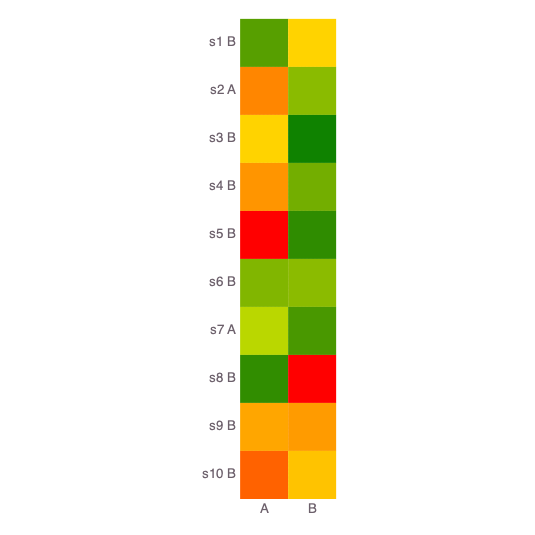

┌ Info: Robust k-means analysis results are loaded from file ./Wmatrix-2-2_100-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:67
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Info: Signal B -> A Count: 2
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:275
┌ Info: Signal A -> B Count: 8
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:275
┌ Info: Signal A (S1) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:292
┌ Info: Signal B (S2) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:292


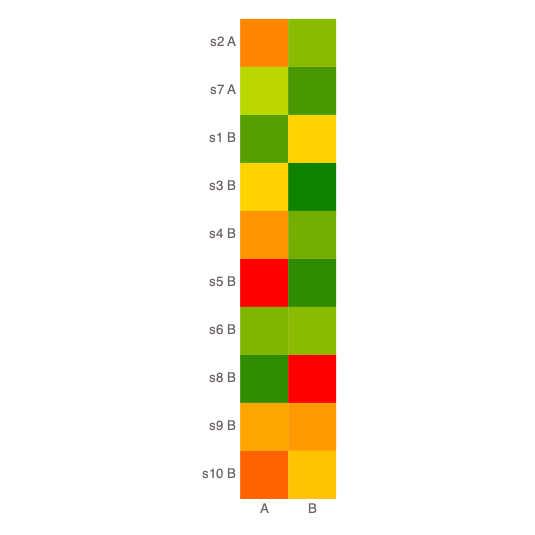

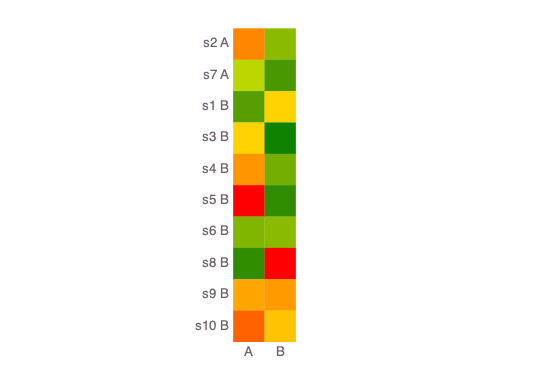

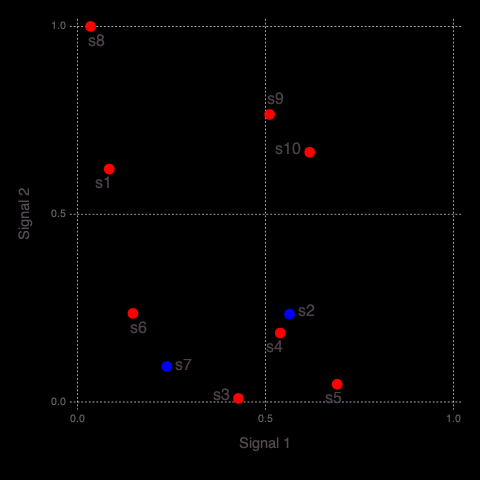

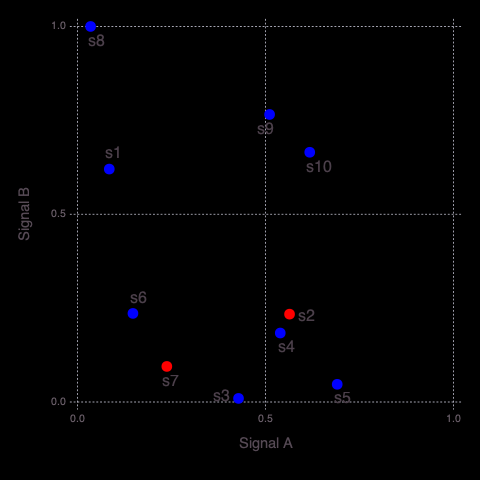

36×2 Matrix{Float64}:
 48.0  1.0
  7.0  0.90646
 50.0  0.811182
 23.0  0.80957
 49.0  0.80668
 45.0  0.799657
 72.0  0.792193
 22.0  0.781473
 32.0  0.75111
 24.0  0.738339
 33.0  0.698459
 62.0  0.698044
 73.0  0.693751
  ⋮    
 60.0  0.54061
 21.0  0.450948
 10.0  0.449086
 34.0  0.437807
 12.0  0.422768
 57.0  0.397088
 61.0  0.3737
 11.0  0.36556
 59.0  0.298814
 19.0  0.298337
 36.0  0.257546
 58.0  0.214994

64×2 Matrix{Float64}:
 29.0  1.0
 28.0  0.994387
 41.0  0.966333
 16.0  0.954458
 15.0  0.947798
 40.0  0.932646
 53.0  0.932094
 27.0  0.923499
  3.0  0.920881
 66.0  0.916317
 54.0  0.907322
 42.0  0.900872
 52.0  0.891139
  ⋮    
 95.0  0.269577
 87.0  0.234987
 74.0  0.231201
 83.0  0.19494
 96.0  0.168447
 99.0  0.124341
 71.0  0.109416
 84.0  0.0915553
 85.0  0.0873578
 98.0  0.0869121
 86.0  0.0792189
 97.0  0.0621416

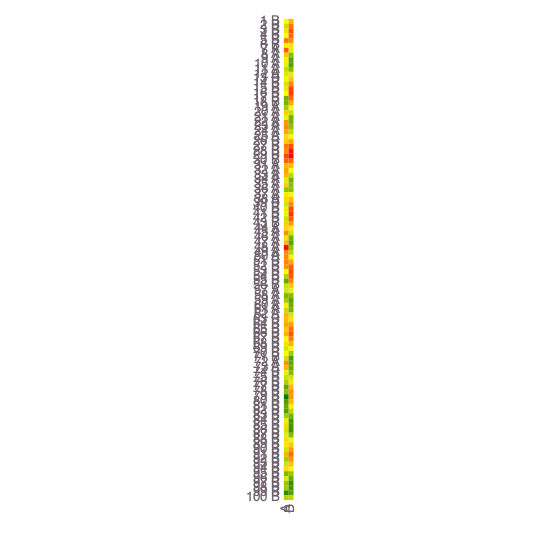

┌ Info: Times (signals=2)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:350
┌ Info: Signal A (S2) Count: 64
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal B (S1) Count: 36
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal B -> A Count: 36
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal A -> B Count: 64
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal A (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:388
┌ Info: Signal B (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:388


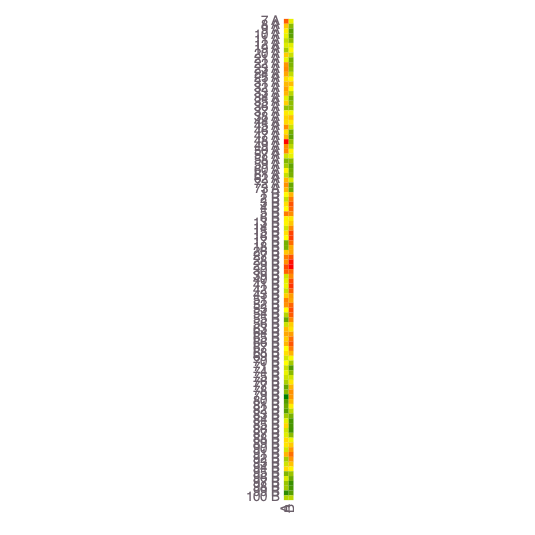

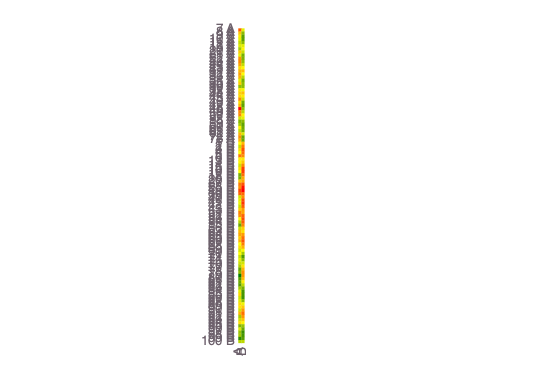

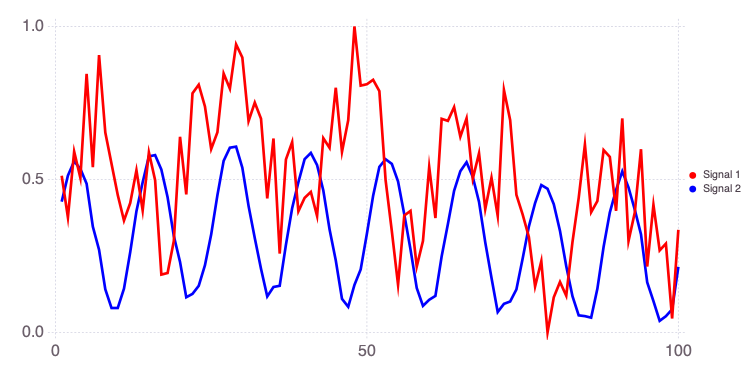

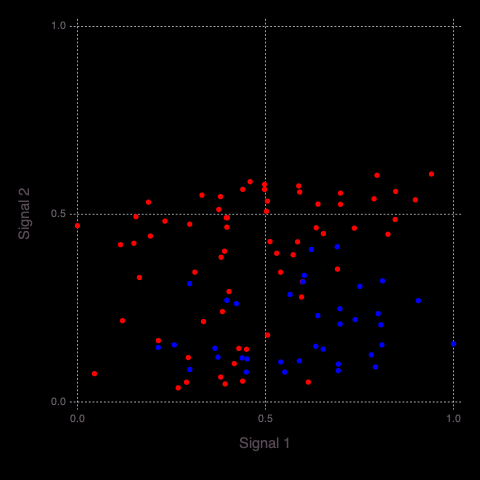

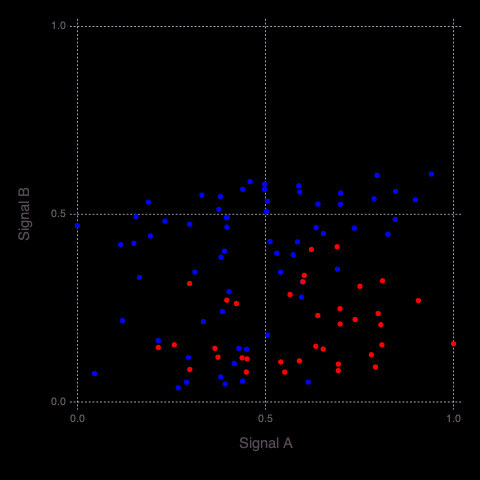

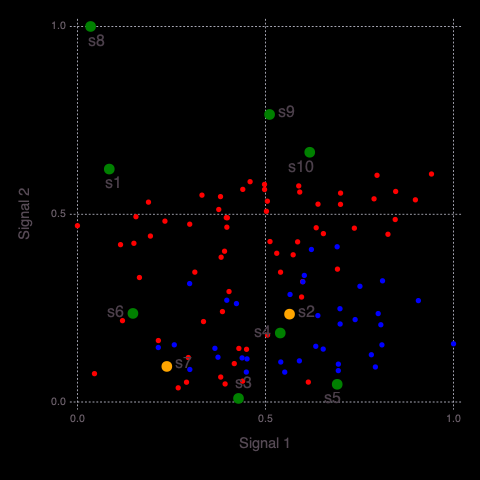

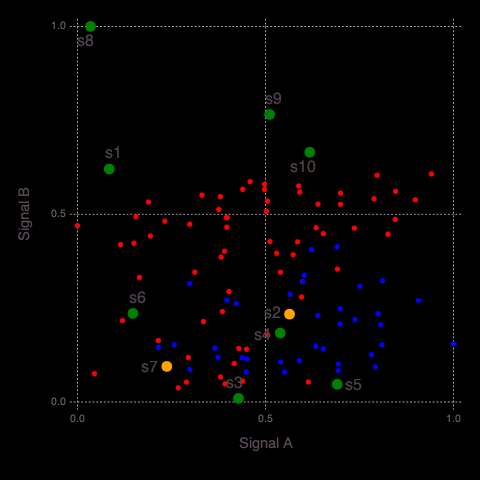

Signal importance (high->low): [3, 2, 1]


┌ Info: Number of signals: 3
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:164
┌ Info: Sensors (signals=3)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:168
┌ Warning: type Clustering.KmeansResult{Core.Array{Core.Float64,2},Core.Float64,Core.Int64} not present in workspace; reconstructing
└ @ JLD /Users/vvv/.julia/packages/JLD/JHrZe/src/jld_types.jl:697
┌ Info: Robust k-means analysis results are loaded from file ./Hmatrix-3-3_10-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:67
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158


3×2 Matrix{Any}:
 "s4"  0.961764
 "s5"  0.9239
 "s3"  0.675083

5×2 Matrix{Any}:
 "s8"   1.0
 "s9"   0.804147
 "s10"  0.642766
 "s1"   0.60861
 "s6"   0.221175

┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: type Clustering.KmeansResult{Core.Array{Core.Float64,2},Core.Float64,Core.Int64} not present in workspace; reconstructing
└ @ JLD /Users/vvv/.julia/packages/JLD/JHrZe/src/jld_types.jl:697
┌ Info: Robust k-means analysis results are loaded from file ./Wmatrix-3-3_100-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:67
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Info: Signal B -> A Count: 3
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:275
┌ Info: Signal A -> B Count: 5
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:275
┌ Info: Signal C -> C Count: 2
└ @ NMFk /Users/vvv/.jul

2×2 Matrix{Any}:
 "s2"  1.0
 "s7"  0.419145

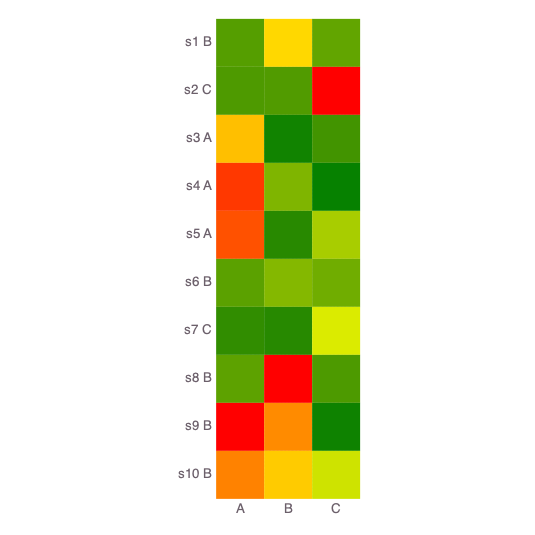

┌ Info: Signal C (S1) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:292


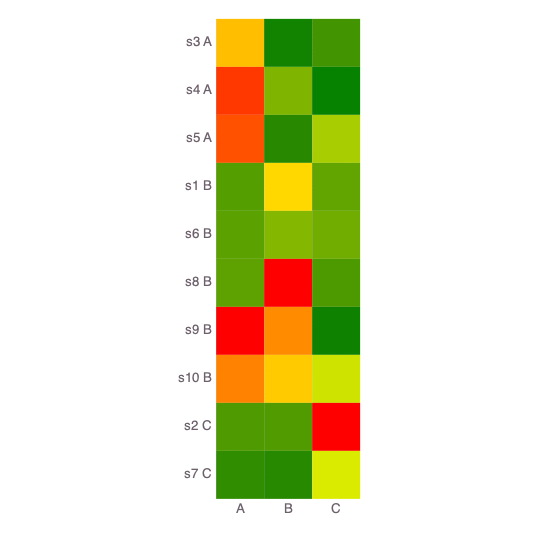

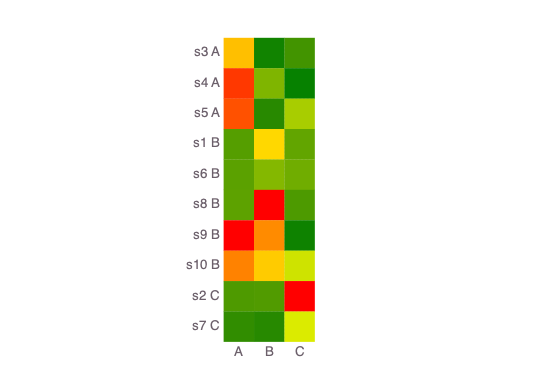

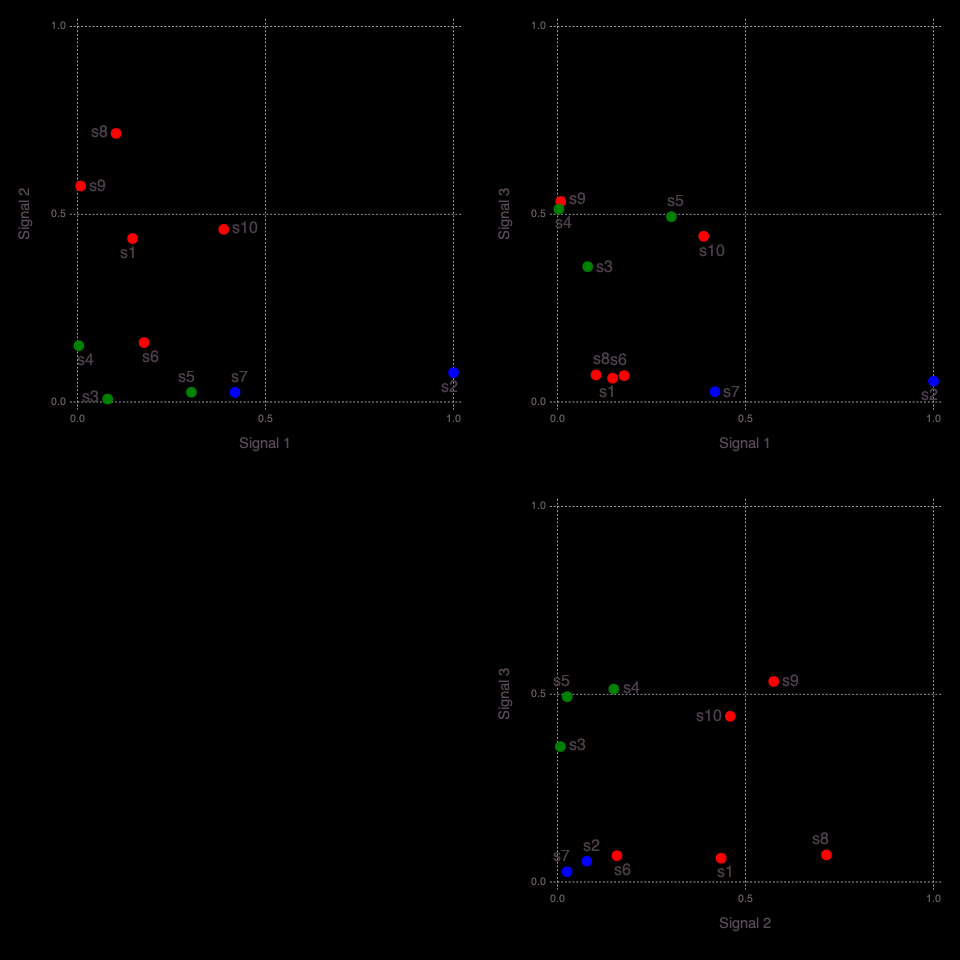

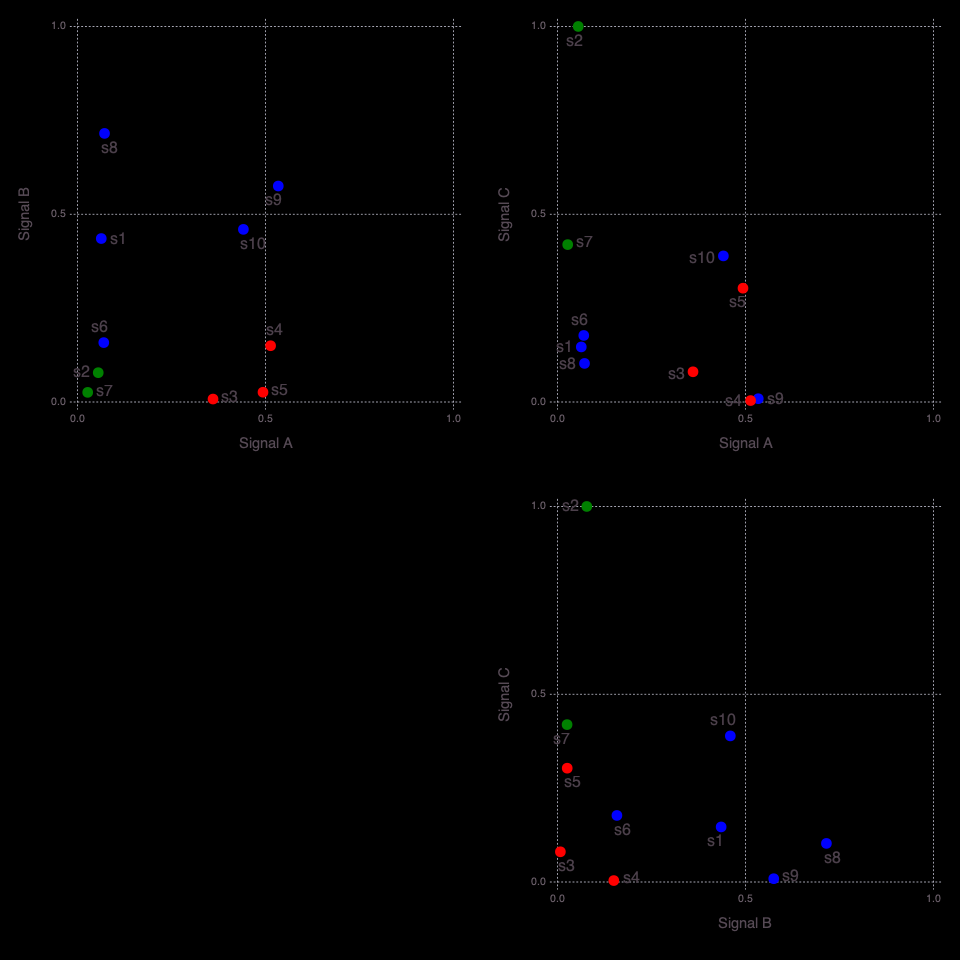

37×2 Matrix{Float64}:
  91.0  0.977447
   5.0  0.929754
  29.0  0.923258
  64.0  0.836318
  66.0  0.827266
  94.0  0.817911
  88.0  0.809029
  27.0  0.807474
  52.0  0.801024
  89.0  0.797584
  63.0  0.751079
  28.0  0.747757
  65.0  0.735548
   ⋮    
 100.0  0.447315
  75.0  0.447037
  76.0  0.370654
   2.0  0.366794
  95.0  0.303642
  78.0  0.294368
  54.0  0.240205
  42.0  0.237622
  81.0  0.212876
  82.0  0.151576
  99.0  0.061458
  79.0  0.0

23×2 Matrix{Float64}:
 41.0  1.0
 16.0  0.98127
 53.0  0.966055
 15.0  0.963061
 40.0  0.961342
 17.0  0.919987
 55.0  0.865718
 30.0  0.844847
 14.0  0.829076
 39.0  0.823647
 80.0  0.785744
 77.0  0.779144
 18.0  0.757396
 51.0  0.689622
 56.0  0.642863
 31.0  0.642328
 13.0  0.638229
 38.0  0.638226
 19.0  0.516139
 57.0  0.42853
 37.0  0.424425
 58.0  0.221269
 34.0  0.127527

40×2 Matrix{Float64}:
 35.0  1.0
 33.0  0.999454
 32.0  0.993931
 23.0  0.970644
 22.0  0.965673
 48.0  0.936445
 24.0  0.930074
 20.0  0.903684
 45.0  0.893843
 25.0  0.852064
 49.0  0.845472
 47.0  0.841897
 21.0  0.82803
  ⋮    
 72.0  0.44919
 73.0  0.404277
 70.0  0.353705
 71.0  0.312965
 74.0  0.303642
 85.0  0.214224
 84.0  0.168959
 83.0  0.126965
 86.0  0.120085
 87.0  0.10552
 98.0  0.100582
 97.0  0.0865212

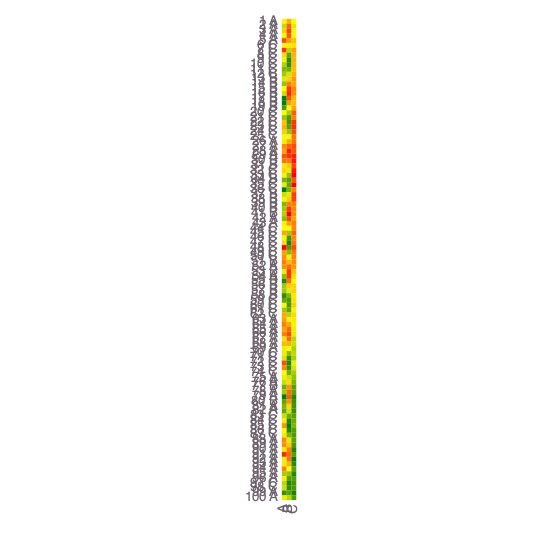

┌ Info: Times (signals=3)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:350
┌ Info: Signal A (S1) Count: 40
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal B (S3) Count: 37
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal C (S2) Count: 23
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal B -> A Count: 37
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal C -> B Count: 23
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal A -> C Count: 40
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal A (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:388
┌ Info: Signal B (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:388
┌ Info: Signal C (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:388


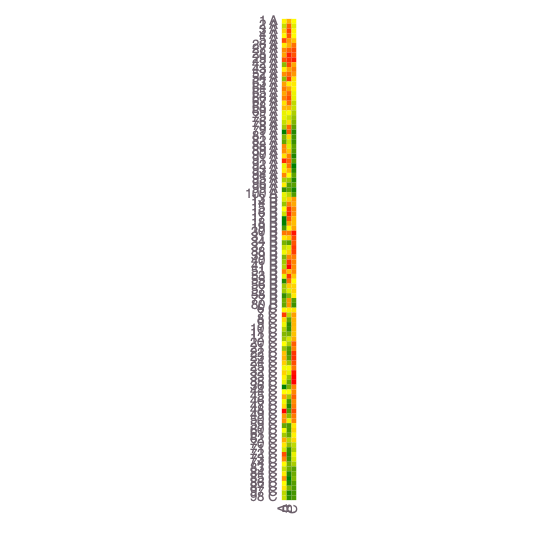

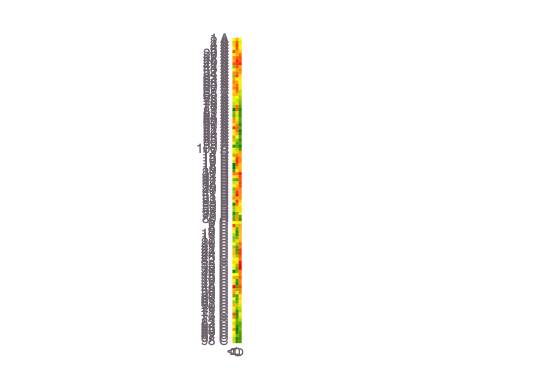

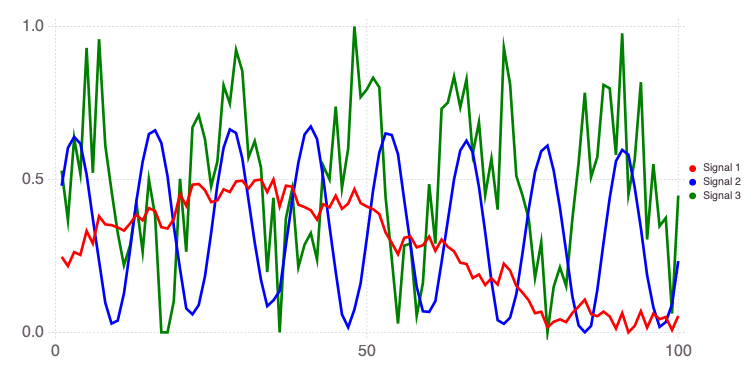

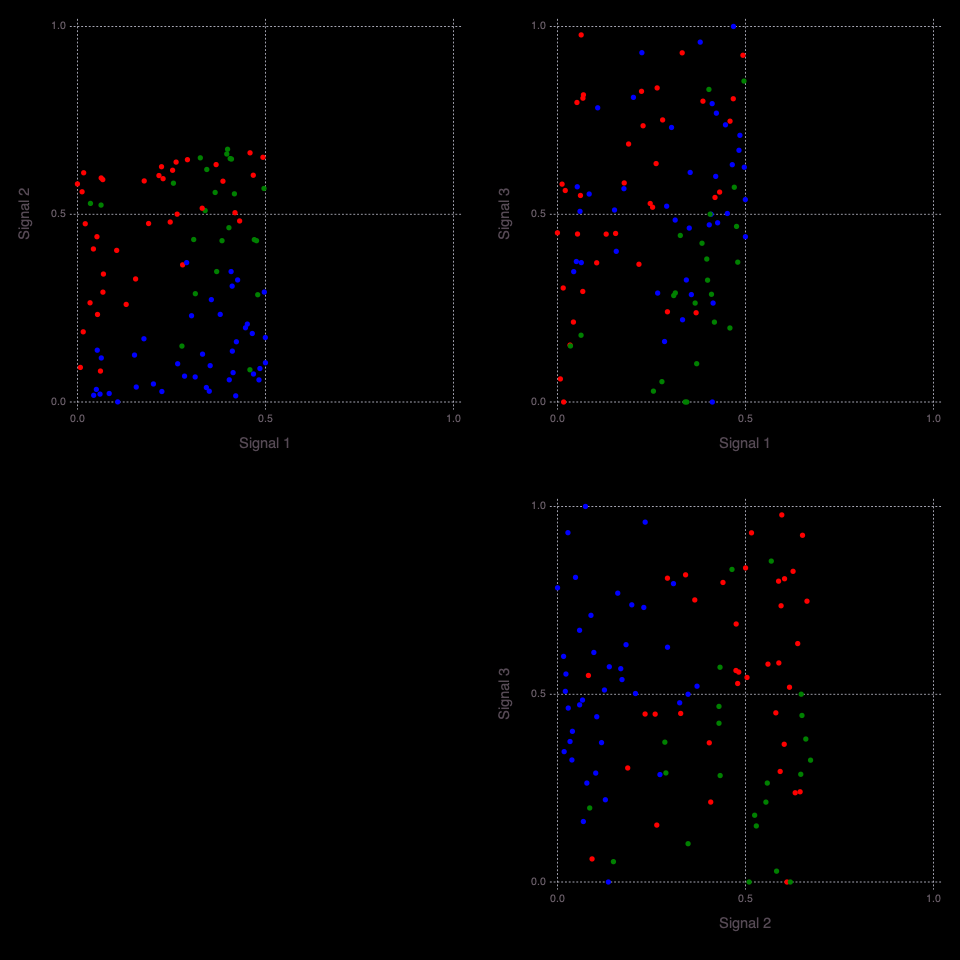

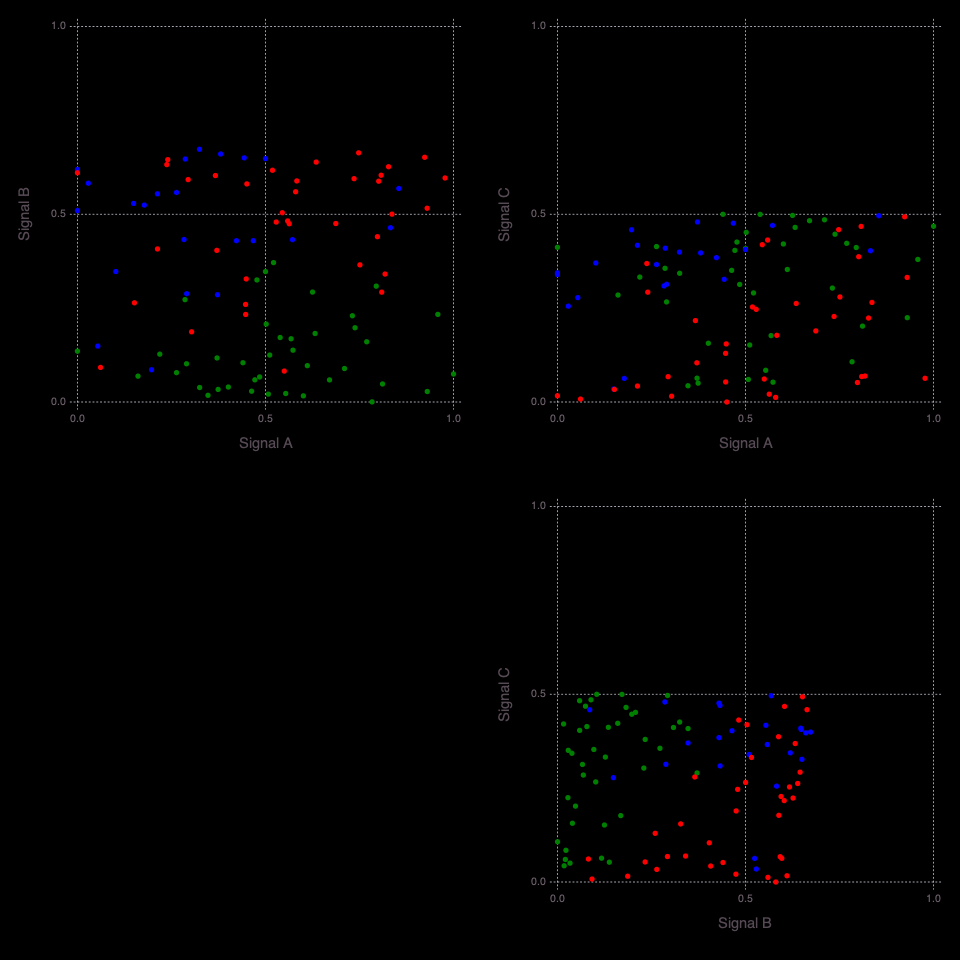

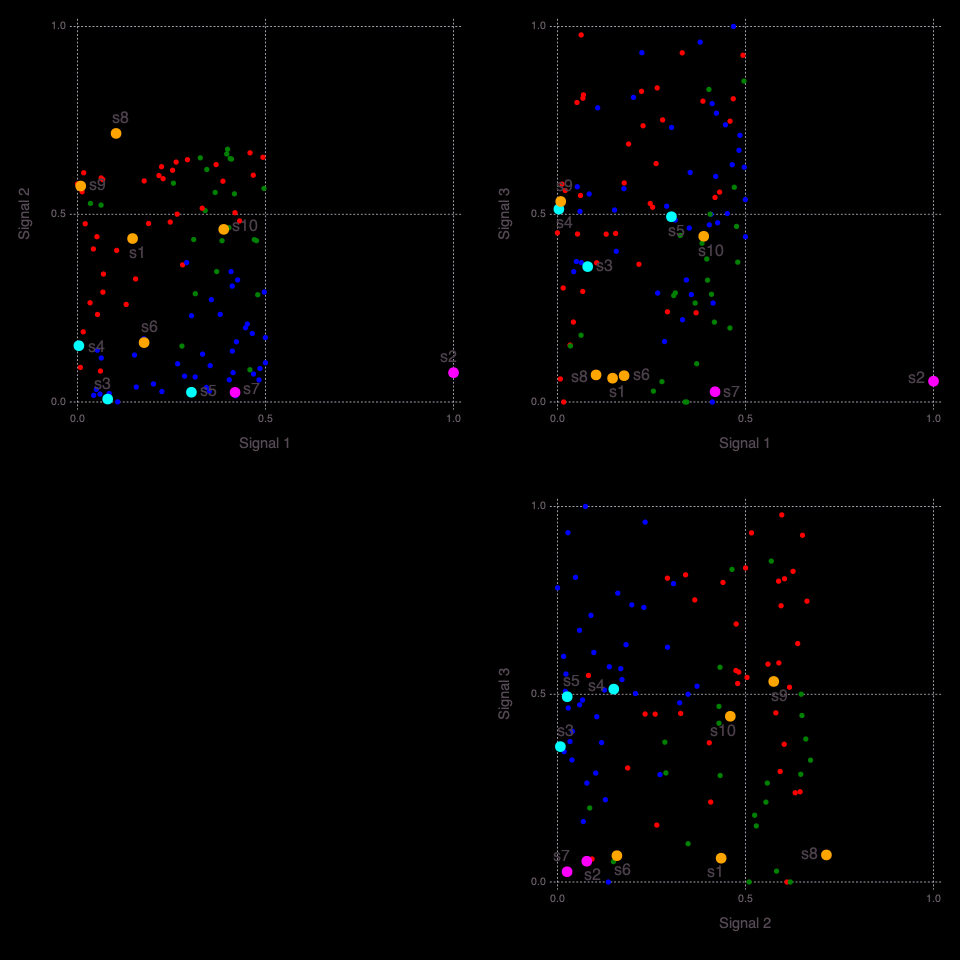

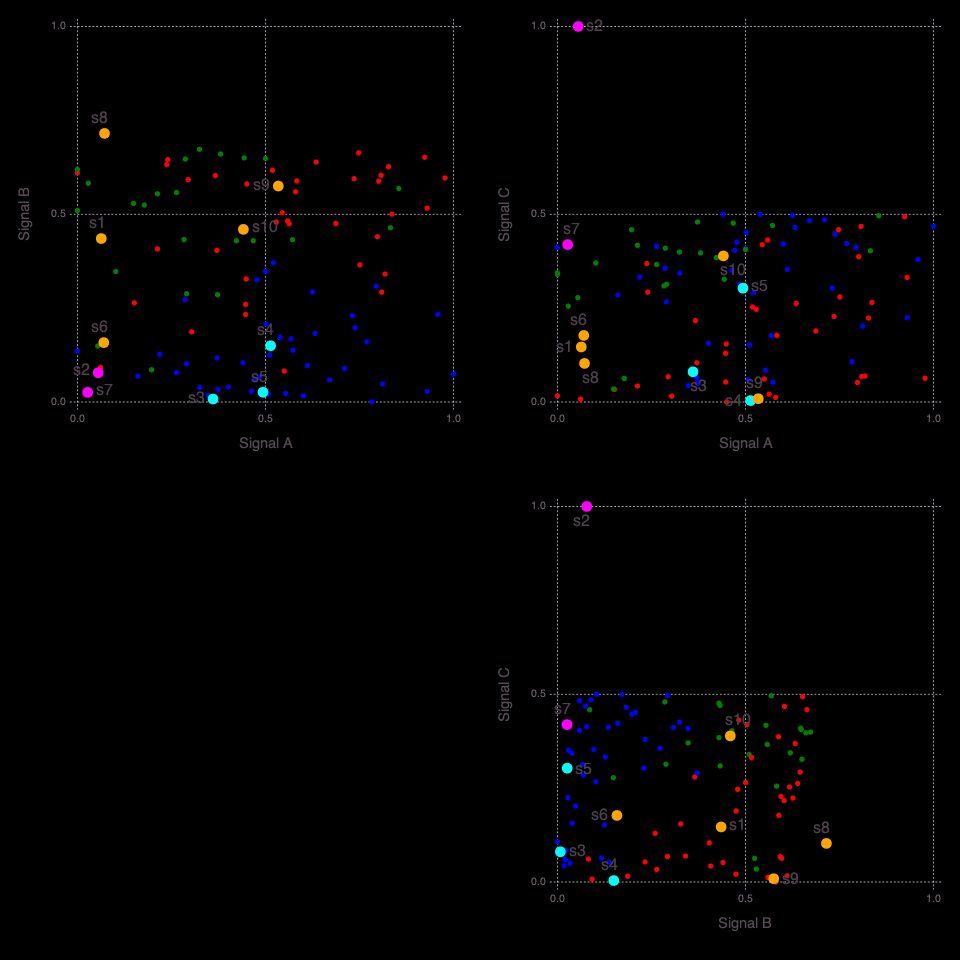

Signal importance (high->low): [4, 3, 2, 1]


┌ Info: Number of signals: 4
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:164
┌ Info: Sensors (signals=4)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:168
┌ Warning: type Clustering.KmeansResult{Core.Array{Core.Float64,2},Core.Float64,Core.Int64} not present in workspace; reconstructing
└ @ JLD /Users/vvv/.julia/packages/JLD/JHrZe/src/jld_types.jl:697


2×2 Matrix{Any}:
 "s5"  1.0
 "s3"  0.802067

3×2 Matrix{Any}:
 "s8"  1.0
 "s9"  0.810281
 "s1"  0.60172

3×2 Matrix{Any}:
 "s4"   1.0
 "s10"  0.605222
 "s6"   0.199823

2×2 Matrix{Any}:
 "s2"  1.0
 "s7"  0.401176

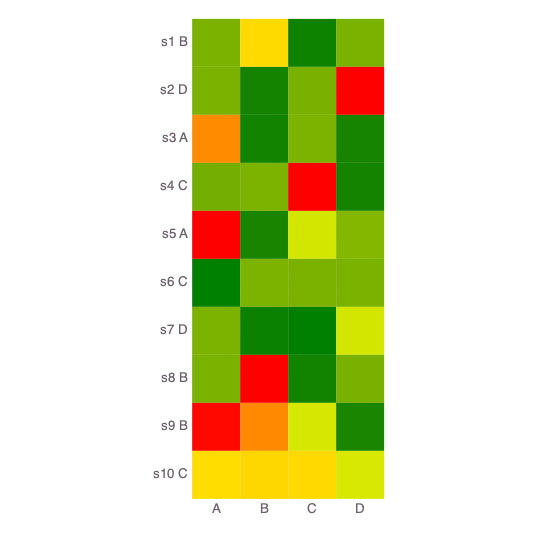

┌ Info: Robust k-means analysis results are loaded from file ./Hmatrix-4-4_10-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:67
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: type Clustering.KmeansResult{Core.Array{Core.Float64,2},Core.Float64,Core.Int64} not present in workspace; reconstructing
└ @ JLD /Users/vvv/.julia/packages/JLD/JHrZe/src/jld_types.jl:697
┌ Info: Robust k-means analysis results are loaded from file ./Wmatrix-4-4_100-1000.jld!
└ @ NMFk /Users/vv

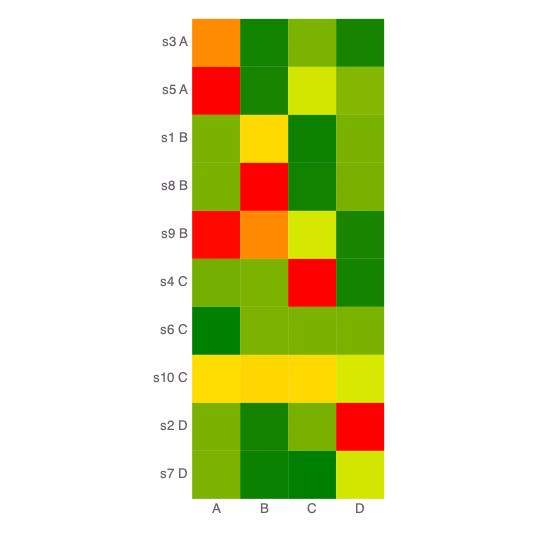

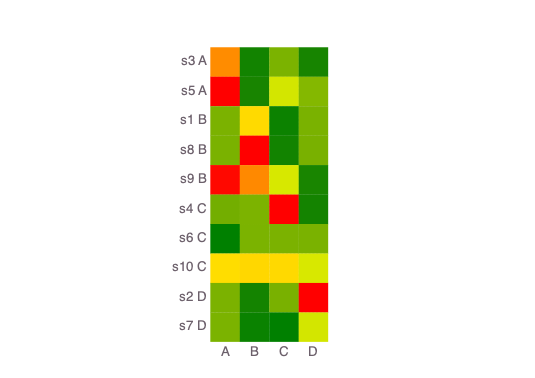

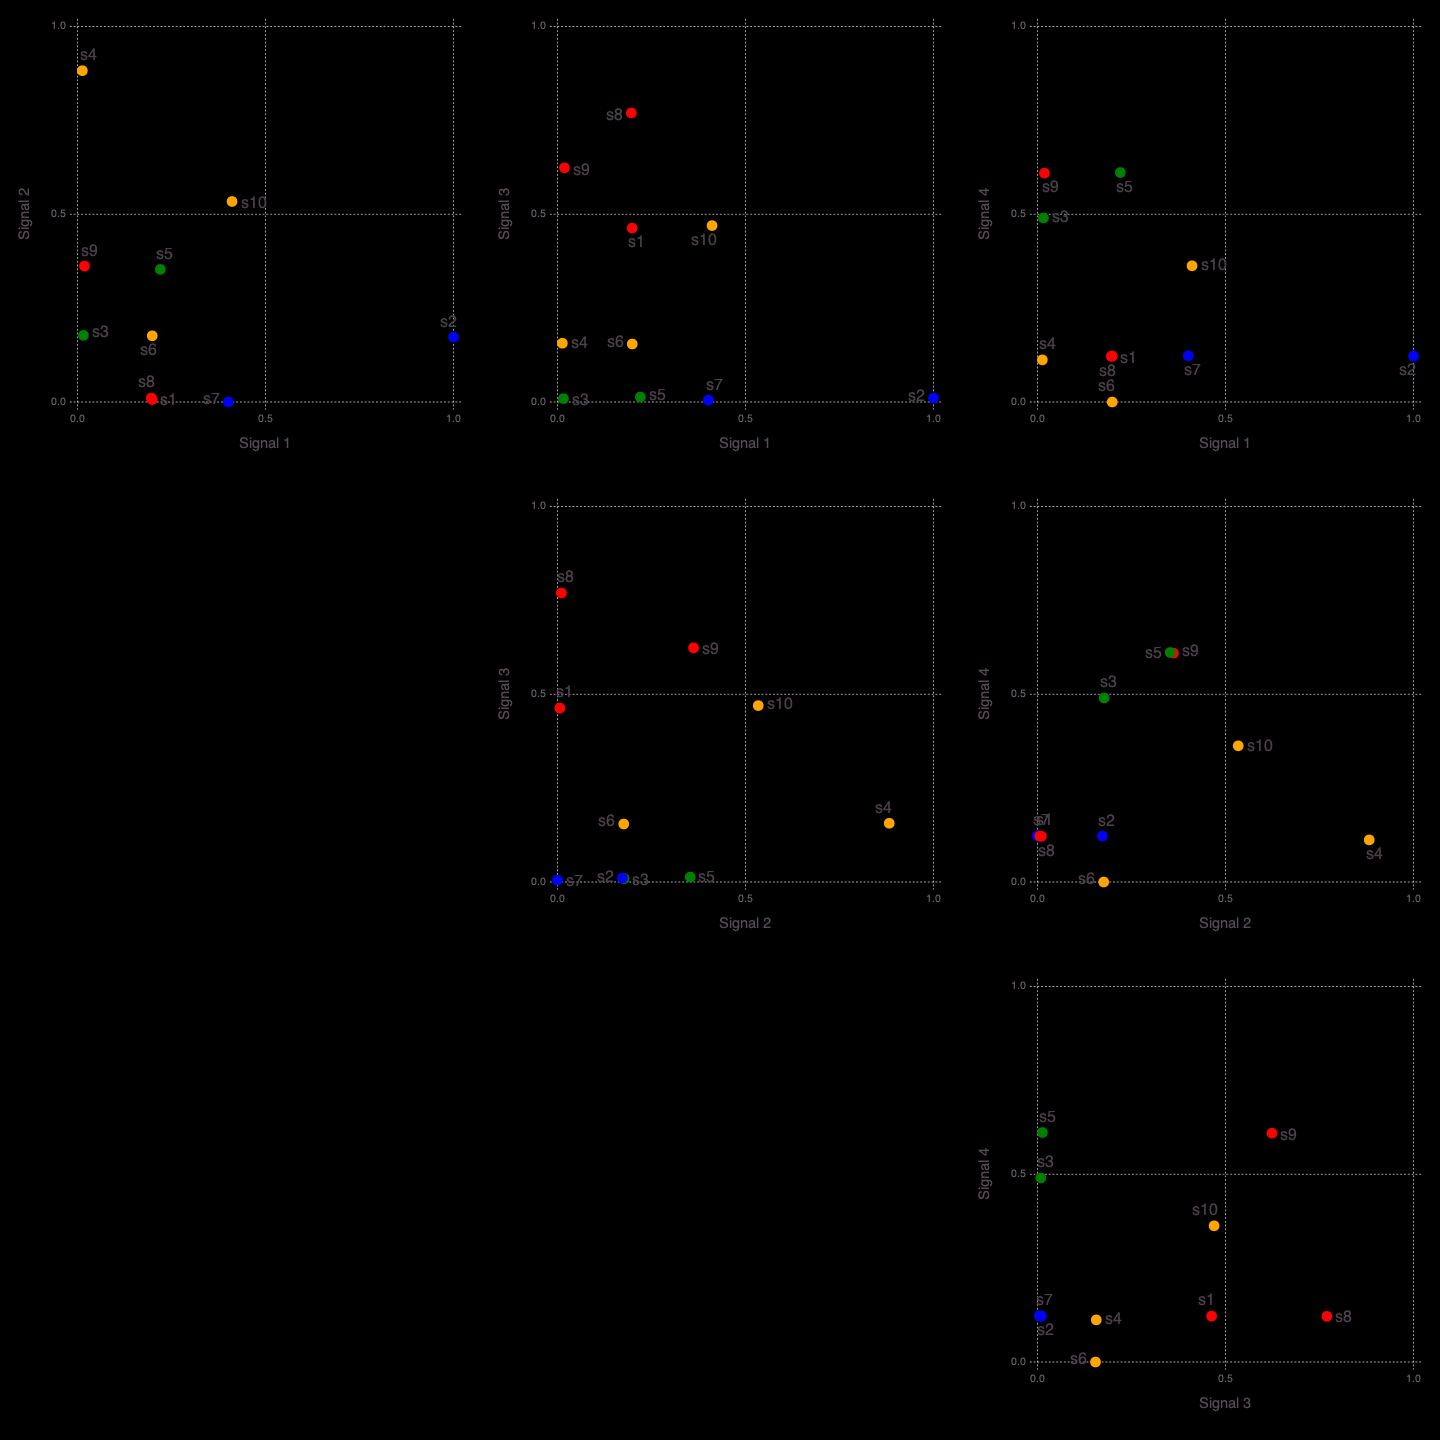

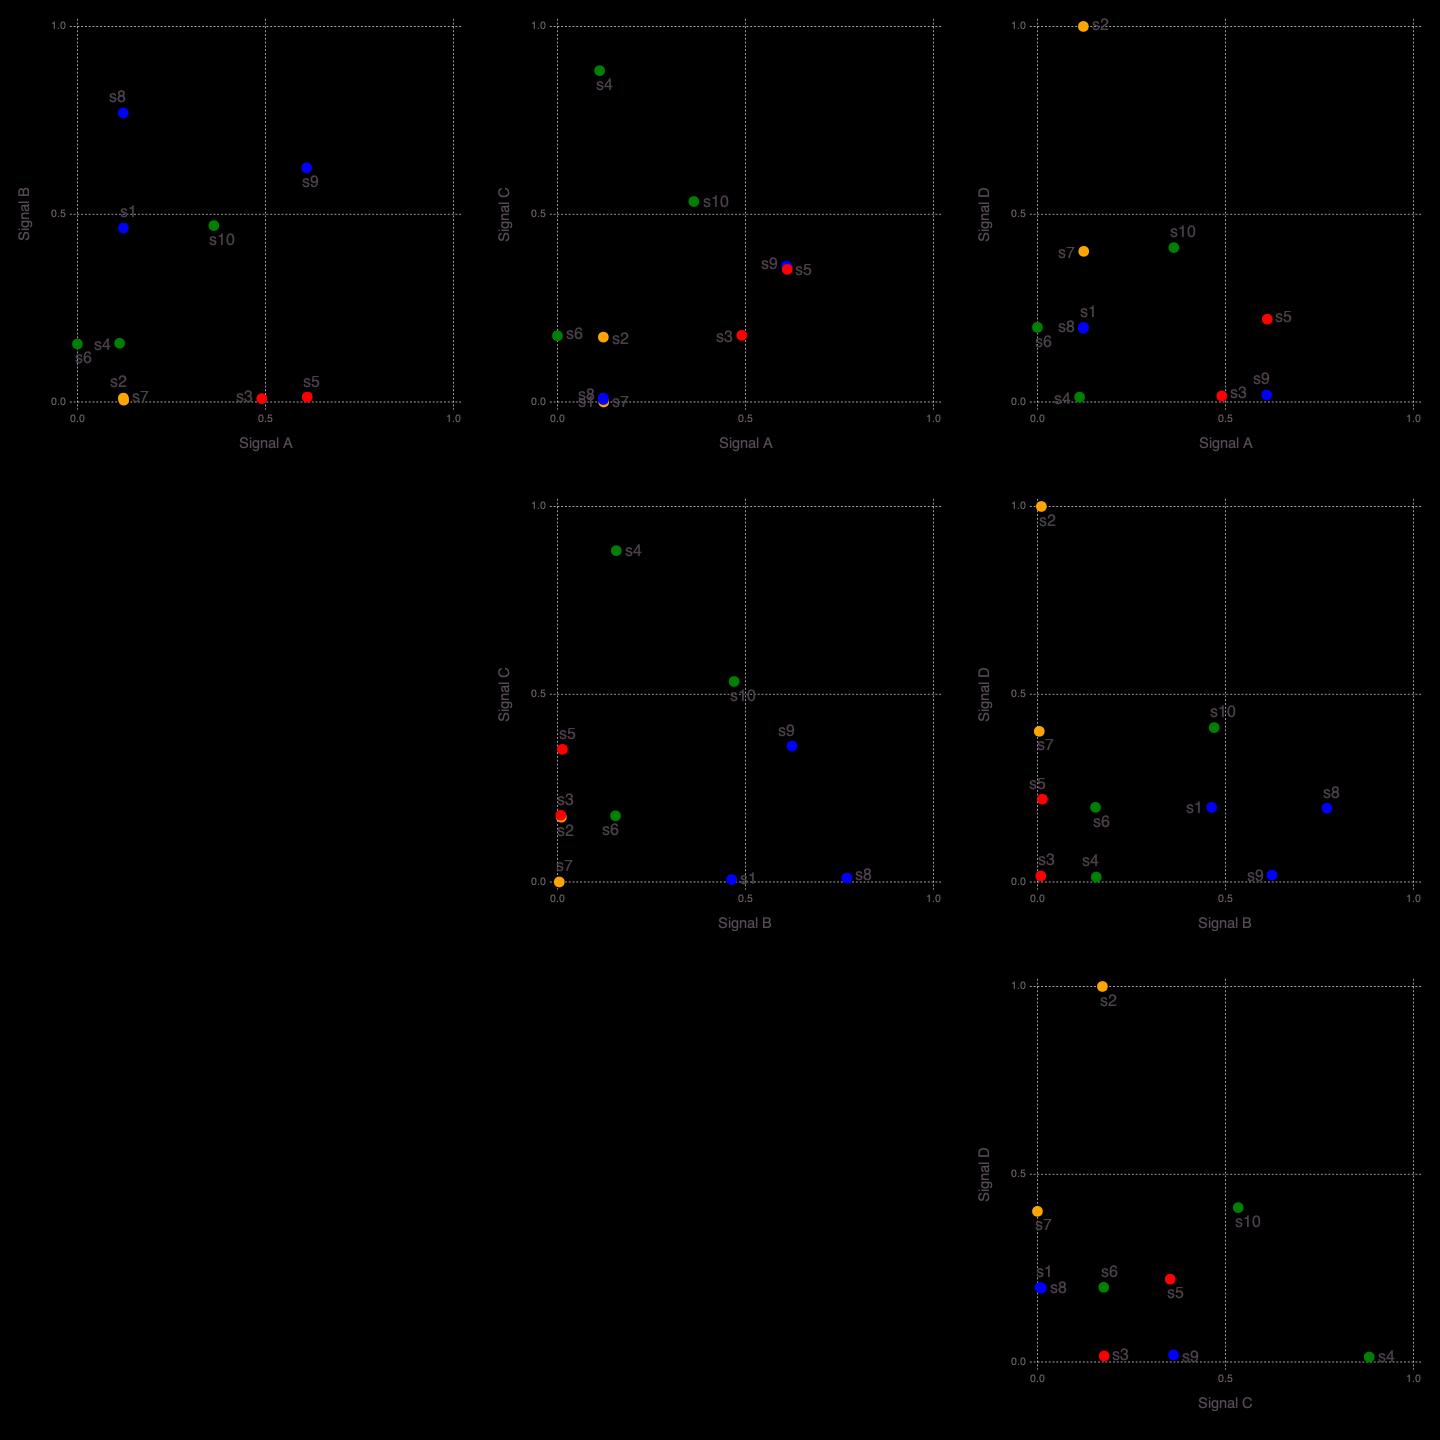

12×2 Matrix{Float64}:
 73.0  0.921292
 48.0  0.920805
  7.0  0.877473
 22.0  0.655249
 23.0  0.608288
 49.0  0.581644
 45.0  0.553796
 34.0  0.302301
  9.0  0.230956
 47.0  0.22555
 10.0  0.118299
 11.0  0.0695206

40×2 Matrix{Float64}:
 41.0  1.0
 16.0  0.999658
 66.0  0.992652
  3.0  0.992084
 28.0  0.99095
 53.0  0.989901
 79.0  0.989034
 78.0  0.982986
 54.0  0.979585
 15.0  0.974543
 29.0  0.964869
 40.0  0.959824
 42.0  0.917565
  ⋮    
 13.0  0.611396
 31.0  0.60331
 38.0  0.581349
 19.0  0.464894
 75.0  0.400071
 57.0  0.3924
 12.0  0.362026
 32.0  0.358336
 37.0  0.33514
 62.0  0.298027
 58.0  0.171558
 99.0  0.15367

21×2 Matrix{Float64}:
 89.0  1.0
  5.0  0.996169
 68.0  0.993815
 26.0  0.984241
 88.0  0.978007
 90.0  0.974038
 67.0  0.966074
  4.0  0.954186
 69.0  0.953466
 91.0  0.918523
 87.0  0.908687
 92.0  0.807659
 86.0  0.806738
 65.0  0.800517
  2.0  0.770976
 30.0  0.703892
 51.0  0.697919
 93.0  0.681621
 63.0  0.528743
 95.0  0.3876
 96.0  0.257164

27×2 Matrix{Float64}:
  33.0  1.0
  35.0  0.993739
  36.0  0.99033
  25.0  0.977145
  24.0  0.970044
  21.0  0.938953
  20.0  0.921989
  44.0  0.905292
  46.0  0.879213
  50.0  0.799437
   8.0  0.69847
   6.0  0.647817
  59.0  0.596794
   ⋮    
  70.0  0.325694
  71.0  0.304884
  72.0  0.279462
  74.0  0.234344
  82.0  0.0877105
  83.0  0.0760717
  84.0  0.0648747
  85.0  0.0522789
 100.0  0.0146202
  98.0  0.00610281
  97.0  0.0035143
  94.0  1.57367e-8

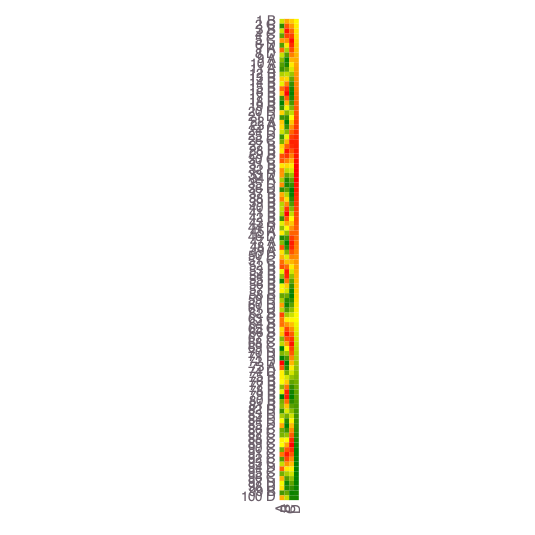

┌ Info: Times (signals=4)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:350
┌ Info: Signal A (S3) Count: 40
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal B (S1) Count: 27
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal C (S2) Count: 21
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal D (S4) Count: 12
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:363
┌ Info: Signal D -> A Count: 12
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal A -> B Count: 40
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal C -> C Count: 21
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal B -> D Count: 27
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:373
┌ Info: Signal A (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:388
┌ Info: Signal B (remapped k-means cluste

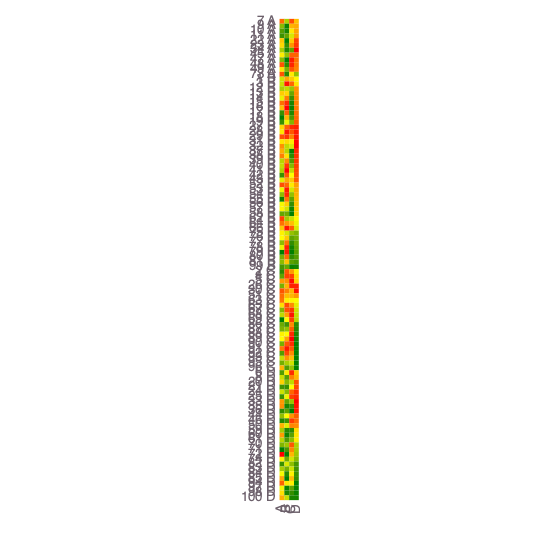

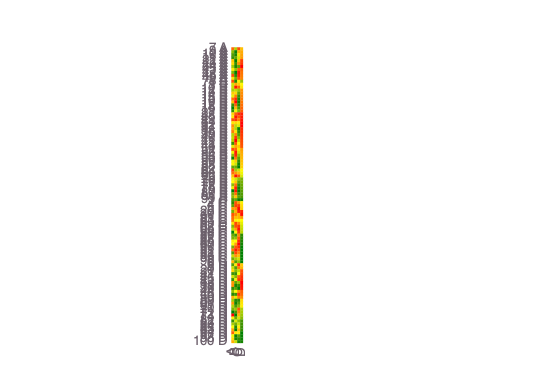

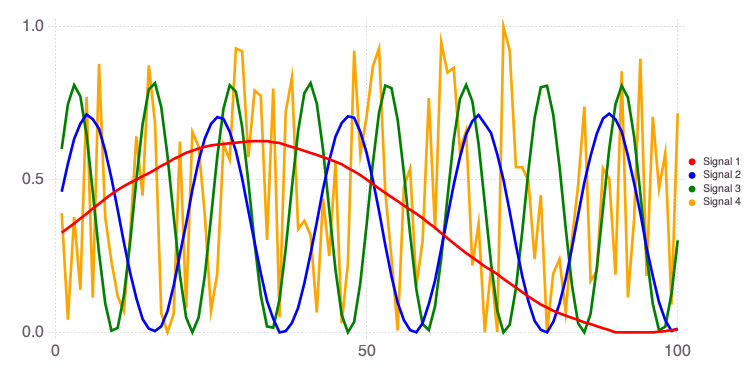

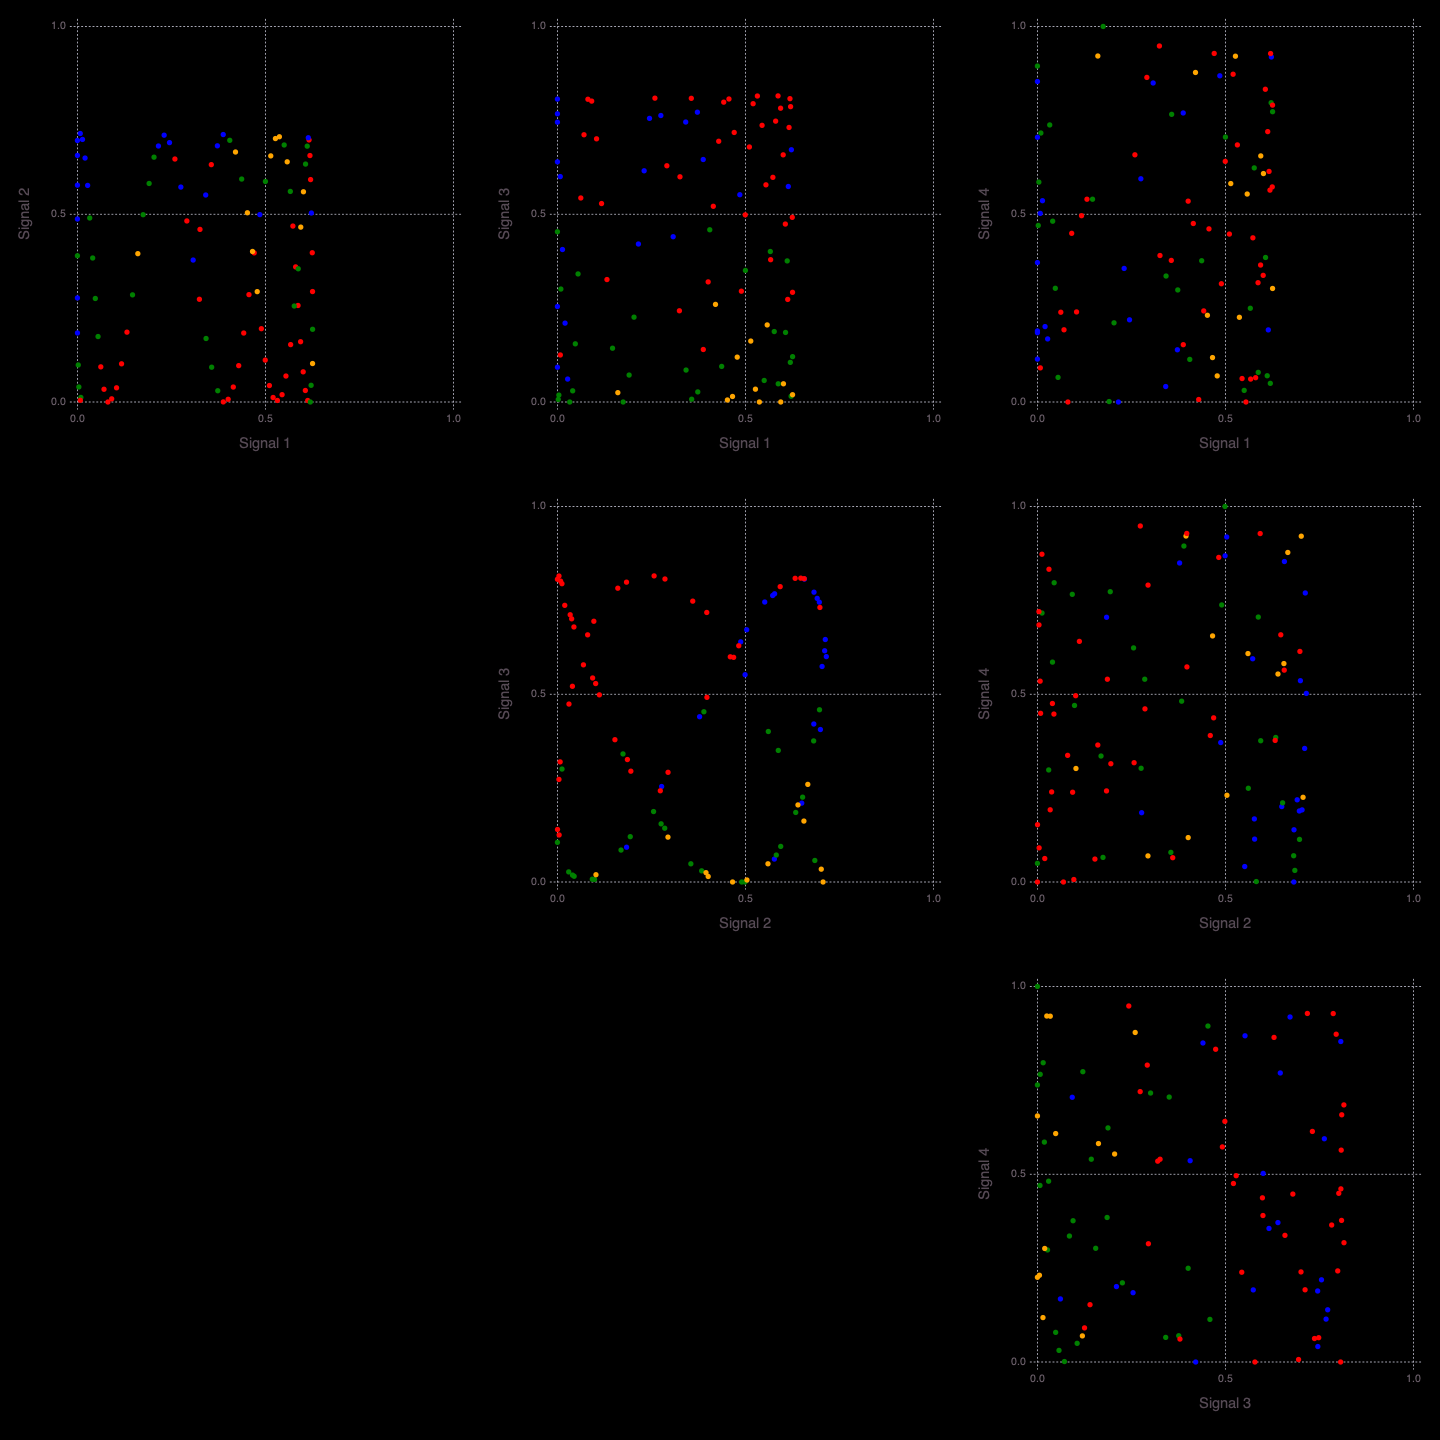

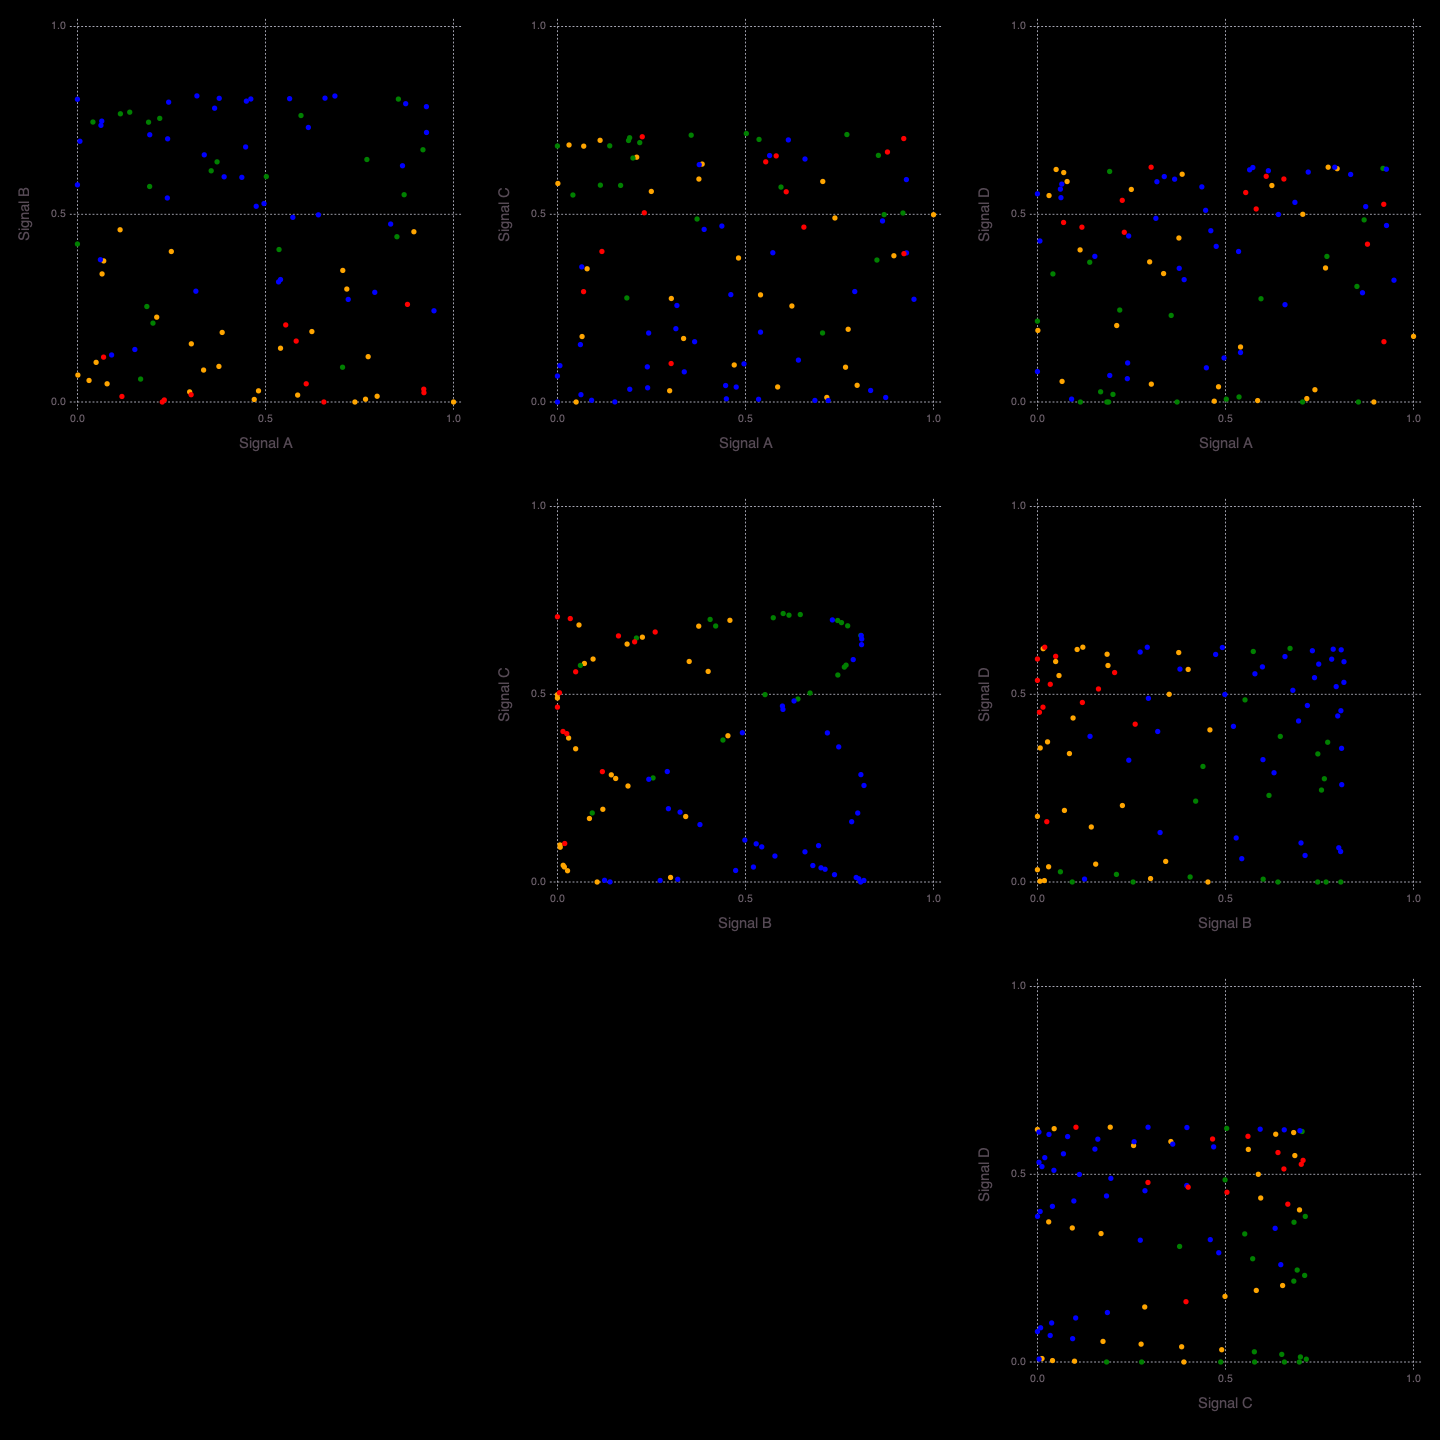

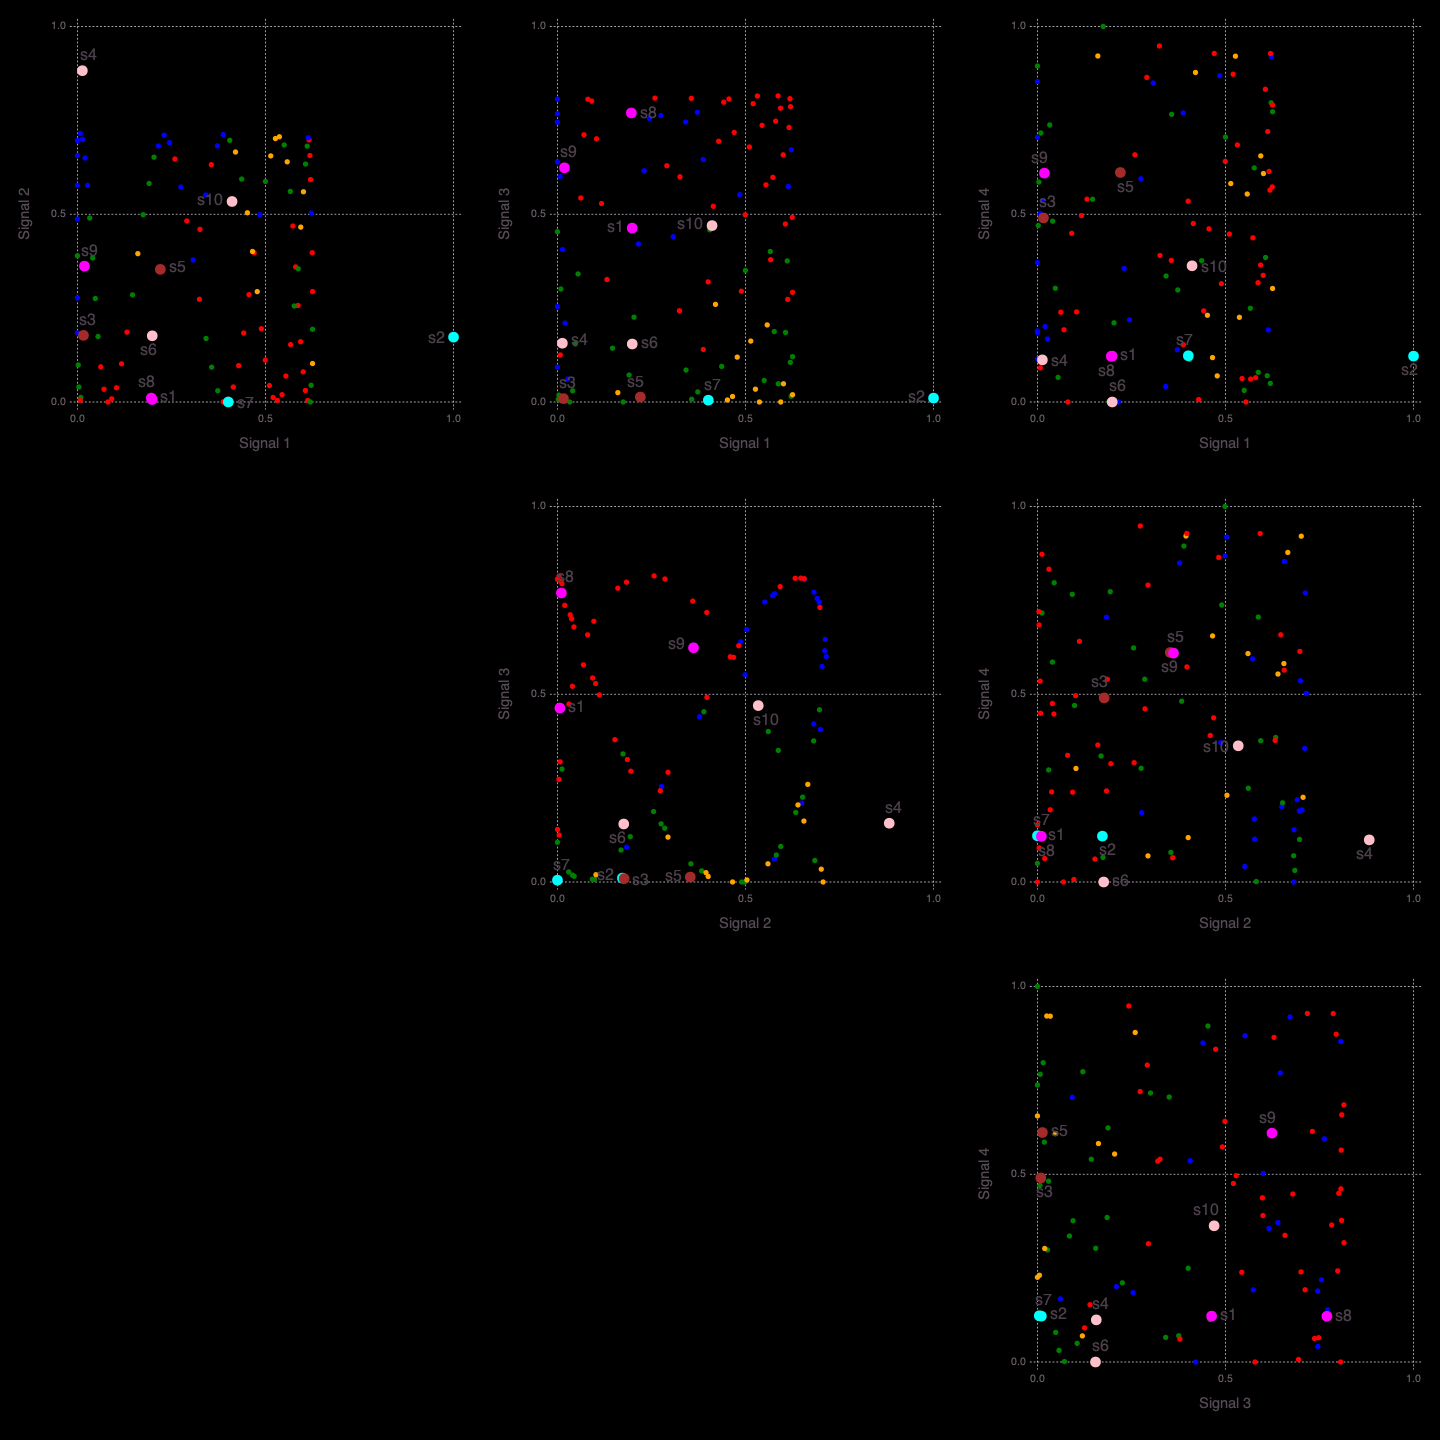

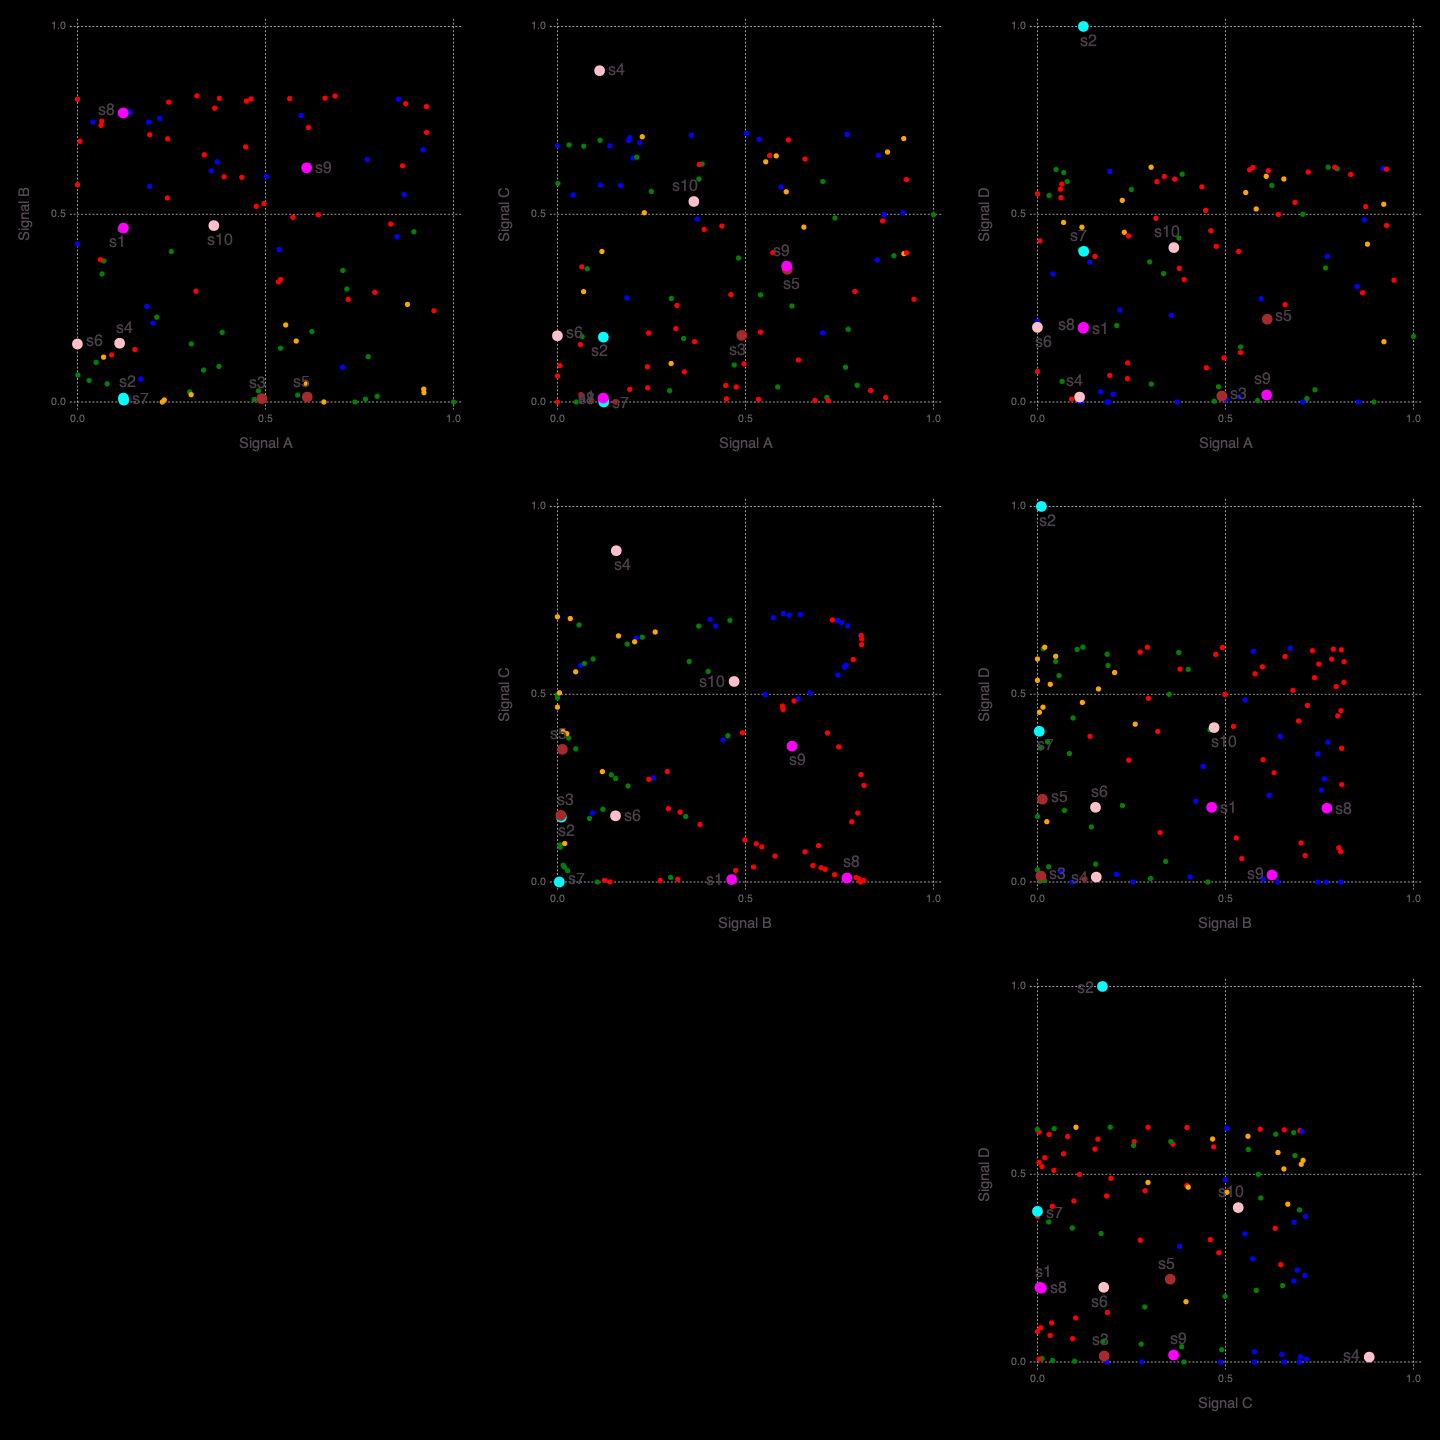

([[1, 2], [3, 2, 1], [4, 3, 2, 1]], [['B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'A'  …  'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'], ['A', 'A', 'A', 'A', 'A', 'C', 'C', 'C', 'C', 'C'  …  'A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'A', 'A'], ['B', 'C', 'B', 'C', 'C', 'D', 'A', 'D', 'A', 'A'  …  'C', 'C', 'C', 'D', 'C', 'C', 'D', 'D', 'B', 'D']], [['B', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B'], ['B', 'C', 'A', 'A', 'A', 'B', 'C', 'B', 'B', 'B'], ['B', 'D', 'A', 'C', 'A', 'C', 'D', 'B', 'B', 'C']])

In [16]:
NMFk.clusterresults(NMFk.getks(nkrange, robustness[nkrange]), We, He, collect(1:100), "s" .* string.(collect(1:10)); Wcasefilename="times", Hcasefilename="sensors", plottimeseries=:W, biplotcolor=:WH, sortmag=false, biplotlabel=:H, point_size_nolabel=2Gadfly.pt, point_size_label=4Gadfly.pt)

The code above perform analyses of all the acceptable solutions.
These are solutions with number of extracted features equal to 2, 3, and 4.
The solution with 4 features is the optimal one.
The solutions for 2 and 3 features are underfitting but informative as well.

Extracted features beased on the solutions for 2, 3, and 4 signals look like this:

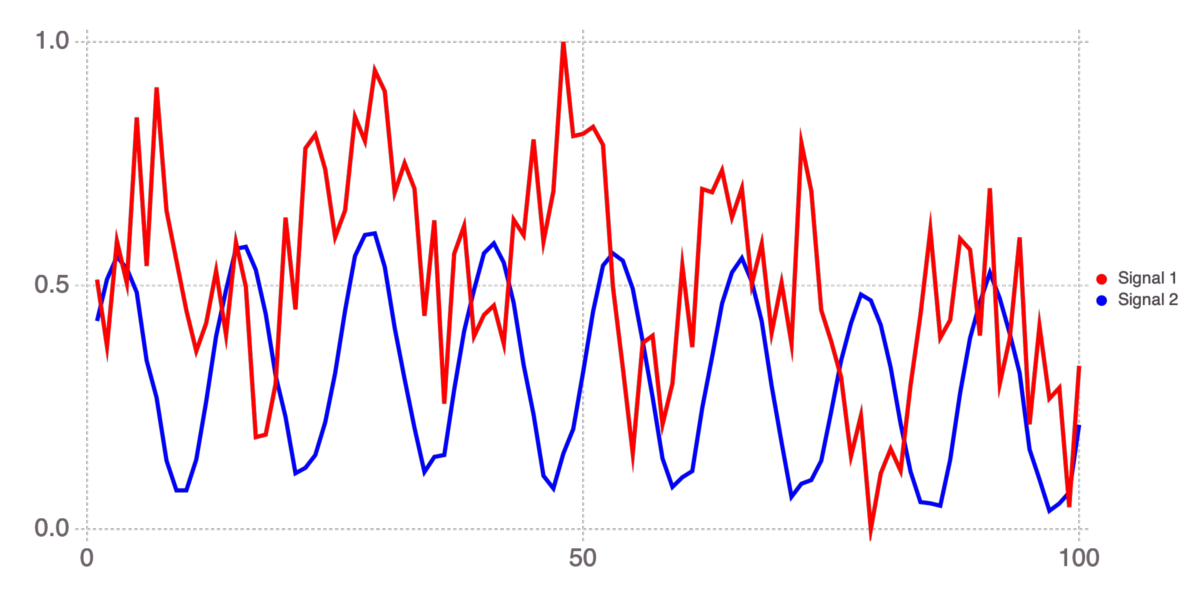

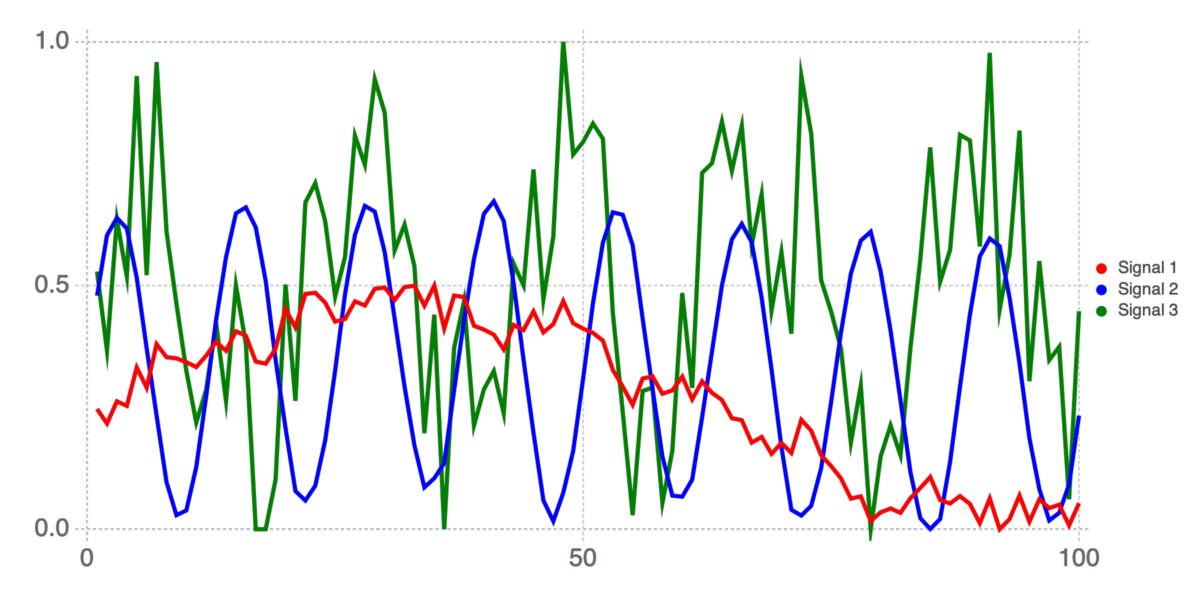

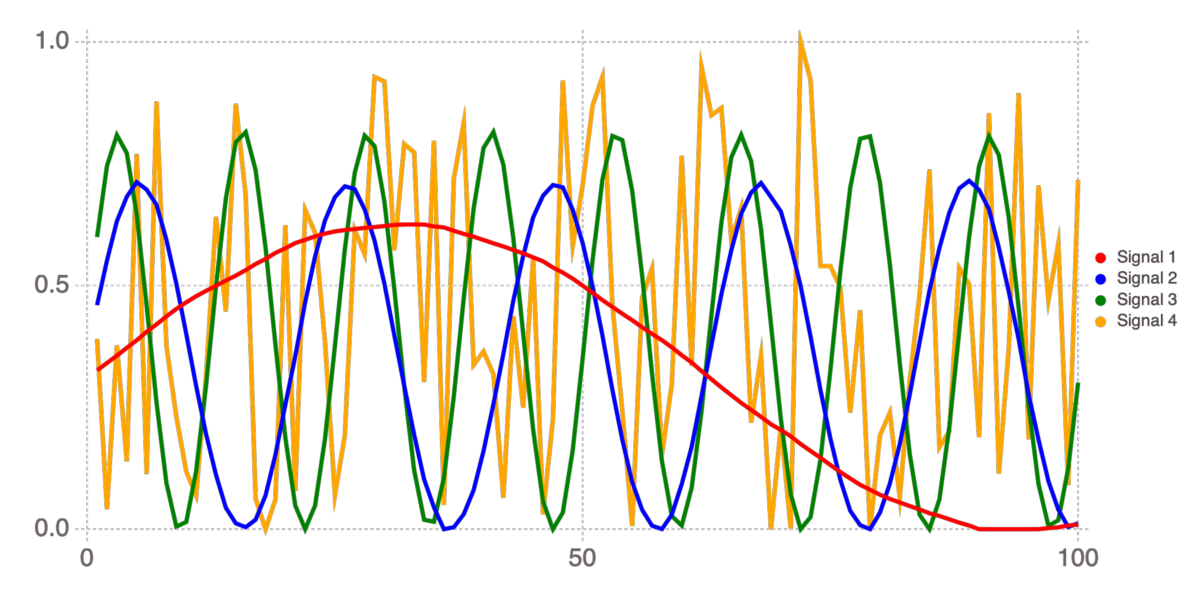

In [17]:
for i = 2:4
	Mads.display("times-$i-timeseries.png")
end

The 10 sensors are grouped intp 4 groups.
The sensor grouping is based on which of the 4 signals are mostly detected by the 4 sensors.
The sensor grouping is listed below:

In [18]:
Mads.display("sensors-4-groups.txt")

Signal A (S4)
s5 	1.0
s3 	0.802

Signal B (S3)
s8 	1.0
s9 	0.81
s1 	0.602

Signal C (S2)
s4 	1.0
s10	0.605
s6 	0.2

Signal D (S1)
s2 	1.0
s7 	0.401



This grouping is based on analyses of the attribute matrix `H` presented below.
The grouping process tries to pick up the most important signal observed by each sensor.
However, there are challanges when more than one signal is present.

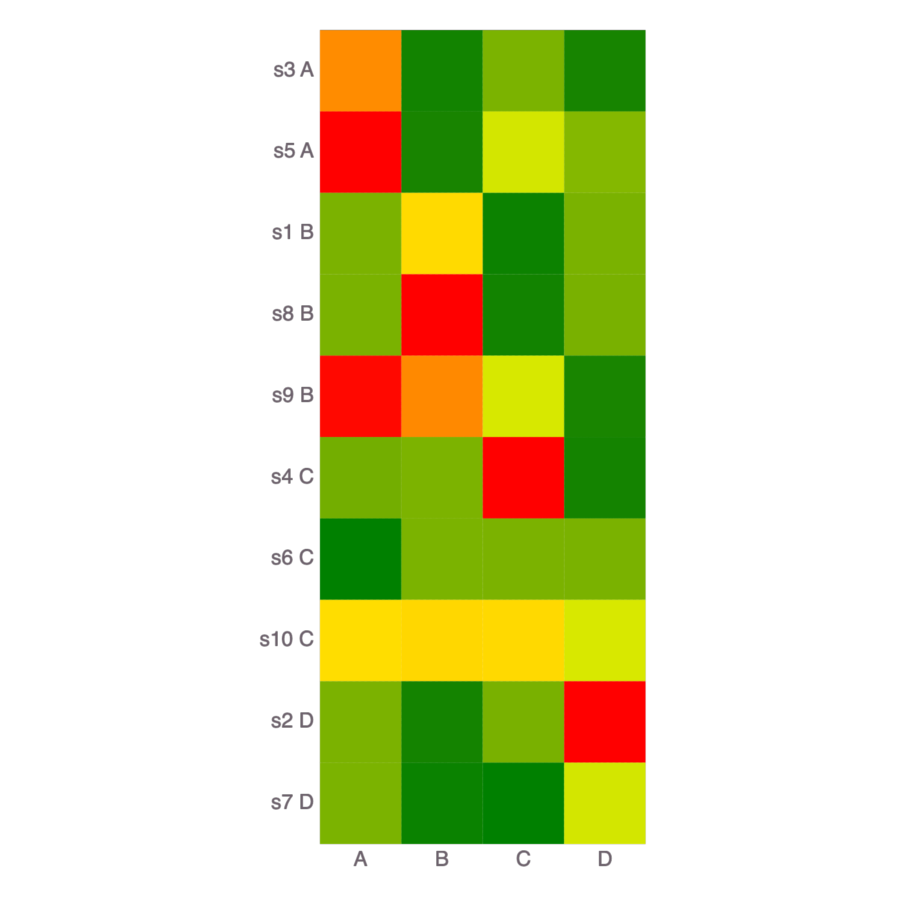

In [19]:
Mads.display("sensors-4-labeled-sorted.png")

The clustering of the sensors into groups at the different levels of clsutering is visualized below:

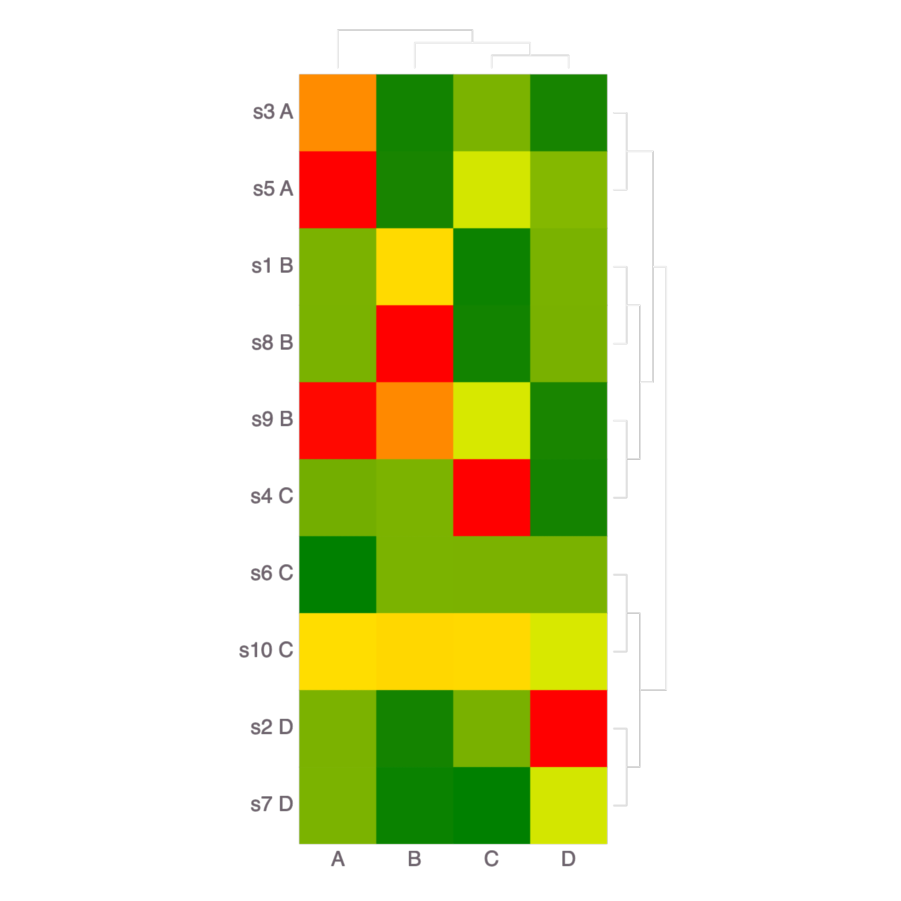

In [20]:
Mads.display("sensors-4-labeled-sorted-dendogram.png")


The biplots below show how the 4 extracted features are projecting the sensors and the timeseries data.
Here, the features are viewed as basis vectors spanning the sensor/time space.
Sensors located along the basis vectors (i.e., plot axes) are the most informative to charecterize the data.
Temporal messurements along the plot axes are also the most important to represent the observed processes.

┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1317


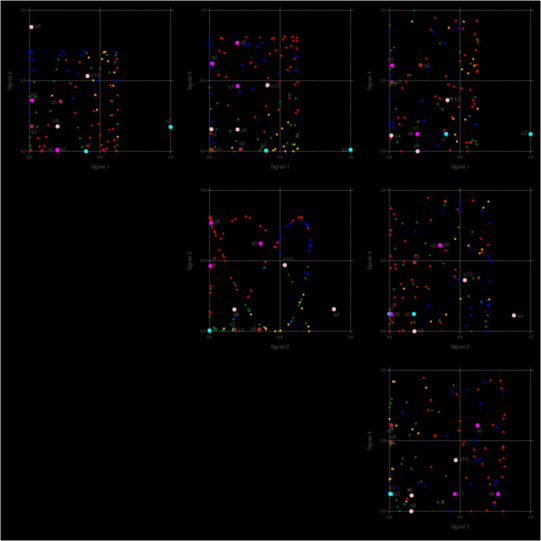

In [21]:
Mads.display("all-4-biplots-original.pdf")